<a href="https://colab.research.google.com/github/cteliStolenFocus/aai-510-team_yash_olympia_chris/blob/main/Final_Project_SU23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install lazypredict
! pip install fasteda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4723 sha256=d0c207050b0bf11e026083552ca447c042f25a16e595fa14e58ea77e1cf4e911
  Stored in directory: /root/.cache/pip/wheels/ed/08/72/0d0ec0d3927d227b38ce9542ec3fa6b975c2e17ad0d046dcee
Successfully built fasteda


In [7]:
import pandas as pd
import numpy as np
import os, sys
import gc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyClassifier
import lazypredict
#Liblaries for cross validation and model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Path used for data storage
default_dir = "/content/aai-510-team_yash_olympia_chris/"

In [8]:
# Reading data from github for the project
!git clone https://github.com/cteliStolenFocus/aai-510-team_yash_olympia_chris

fatal: destination path 'aai-510-team_yash_olympia_chris' already exists and is not an empty directory.


## greeks.csv - Supplemental metadata, only available for the training set.

##    Alpha Identifies the type of age-related condition, if present.
##

1.   A No age-related condition. Corresponds to class 0.
2.   B, D, G The three age-related conditions. Correspond to class 1.

Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [9]:
greeks_data = pd.read_csv(os.path.join(default_dir,'greeks.csv'))

print(f'greeks Data Shape: {greeks_data.shape}')

greeks_data.head()

greeks Data Shape: (617, 6)


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


train.csv - The training set.

*   Id Unique identifier for each observation.
*   AB-GL 56 anonymized health characteristics. All are numeric except  for EJ, which is categorical.
*   Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions
*   0 indicates they have not.



In [10]:
train_df = pd.read_csv(os.path.join(default_dir,'train.csv'))

print(f'Training Data Shape: {train_df.shape}')

train_df.head()

Training Data Shape: (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.21,3109.03,85.20,22.39,8.14,0.70,0.03,9.81,5.56,...,7.30,1.74,0.09,11.34,72.61,2003.81,22.14,69.83,0.12,1
1,007255e47698,0.15,978.76,85.20,36.97,8.14,3.63,0.03,13.52,1.23,...,0.17,0.50,0.57,9.29,72.61,27981.56,29.14,32.13,21.98,0
2,013f2bd269f5,0.47,2635.11,85.20,32.36,8.14,6.73,0.03,12.82,1.23,...,7.71,0.98,1.20,37.08,88.61,13676.96,28.02,35.19,0.20,0
3,043ac50845d5,0.25,3819.65,120.20,77.11,8.14,3.69,0.03,11.05,1.23,...,6.12,0.50,0.28,18.53,82.42,2094.26,39.95,90.49,0.16,0
4,044fb8a146ec,0.38,3733.05,85.20,14.10,8.14,3.94,0.05,3.40,102.15,...,8.15,48.50,0.12,16.41,146.11,8524.37,45.38,36.26,0.10,1


DataFrame Head:


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.21,3109.03,85.20,22.39,8.14,0.70,0.03,9.81,5.56,4126.59,22.60,175.64,152.71,823.93,257.43,47.22,0.56,23.39,4.85,0.02,1.05,0.07,13.78,1.30,36.21,69.08,295.57,0.24,0.28,89.25,84.32,29.66,5.31,1.74,23.19,7.29,1.99,1433.17,0.95,B,30.88,78.53,3.83,13.39,10.27,9028.29,3.58,7.30,1.74,0.09,11.34,72.61,2003.81,22.14,69.83,0.12,1
1,007255e47698,0.15,978.76,85.20,36.97,8.14,3.63,0.03,13.52,1.23,5496.93,19.42,155.87,14.75,51.22,257.43,30.28,0.48,50.63,6.09,0.03,1.11,1.12,28.31,1.36,37.48,70.80,178.55,0.24,0.36,110.58,75.75,37.53,0.01,1.74,17.22,4.93,0.86,1111.29,0.00,A,109.13,95.42,52.26,17.18,0.30,6785.00,10.36,0.17,0.50,0.57,9.29,72.61,27981.56,29.14,32.13,21.98,0
2,013f2bd269f5,0.47,2635.11,85.20,32.36,8.14,6.73,0.03,12.82,1.23,5135.78,26.48,128.99,219.32,482.14,257.43,32.56,0.50,85.96,5.38,0.04,1.05,0.70,39.36,1.01,21.46,70.82,321.43,0.24,0.21,120.06,65.47,28.05,1.29,1.74,36.86,7.81,8.15,1494.08,0.38,B,109.13,78.53,5.39,224.21,8.75,8338.91,11.63,7.71,0.98,1.20,37.08,88.61,13676.96,28.02,35.19,0.20,0


DataFrame Tail:


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
614,fd8ef6377f76,0.43,2459.11,130.14,55.36,10.01,8.07,0.03,15.41,1.23,5888.88,20.48,178.66,103.99,2083.88,257.43,90.41,0.71,142.68,7.81,0.03,1.50,0.88,39.36,1.49,36.81,104.62,223.21,0.24,0.38,218.92,326.24,26.46,0.01,1.74,47.55,9.48,2.23,2565.40,0.00,A,109.13,87.40,3.83,71.73,0.30,5088.92,12.03,0.17,0.50,0.07,19.96,128.90,6474.65,26.17,119.56,21.98,0
615,fe1942975e40,0.36,1263.54,85.20,23.69,8.14,7.98,0.03,7.52,1.23,4517.87,19.07,119.16,NaN,722.38,257.43,12.50,0.60,122.94,2.96,0.02,1.05,0.58,34.37,1.43,36.70,51.04,112.20,0.53,0.55,113.53,96.97,27.10,0.51,1.74,38.27,10.08,1.63,1318.96,0.14,B,NaN,99.71,8.26,38.13,6.19,6464.25,8.03,9.26,0.79,0.67,24.59,72.61,1965.34,25.12,37.16,0.18,0
616,ffcca4ded3bb,0.48,2672.53,546.66,112.01,8.14,3.20,0.12,3.40,7.95,2818.02,21.19,306.13,6.09,747.47,257.43,67.22,0.64,271.24,10.48,0.08,1.24,2.40,42.80,0.92,37.82,35.73,889.50,0.24,0.17,156.35,82.54,21.09,0.01,1.74,24.50,7.87,2.37,912.31,0.00,A,15.96,181.22,78.37,66.89,0.30,5895.35,7.75,0.17,1.14,0.15,13.67,72.61,6850.48,45.75,114.84,21.98,0


----------------------------------------------------------------------------------------------------
Missing values:


,0
BQ,60
CB,2
CC,3
DU,1
EL,60
FC,1
FL,1
FS,2
GL,1


----------------------------------------------------------------------------------------------------
MSNO Matrix:



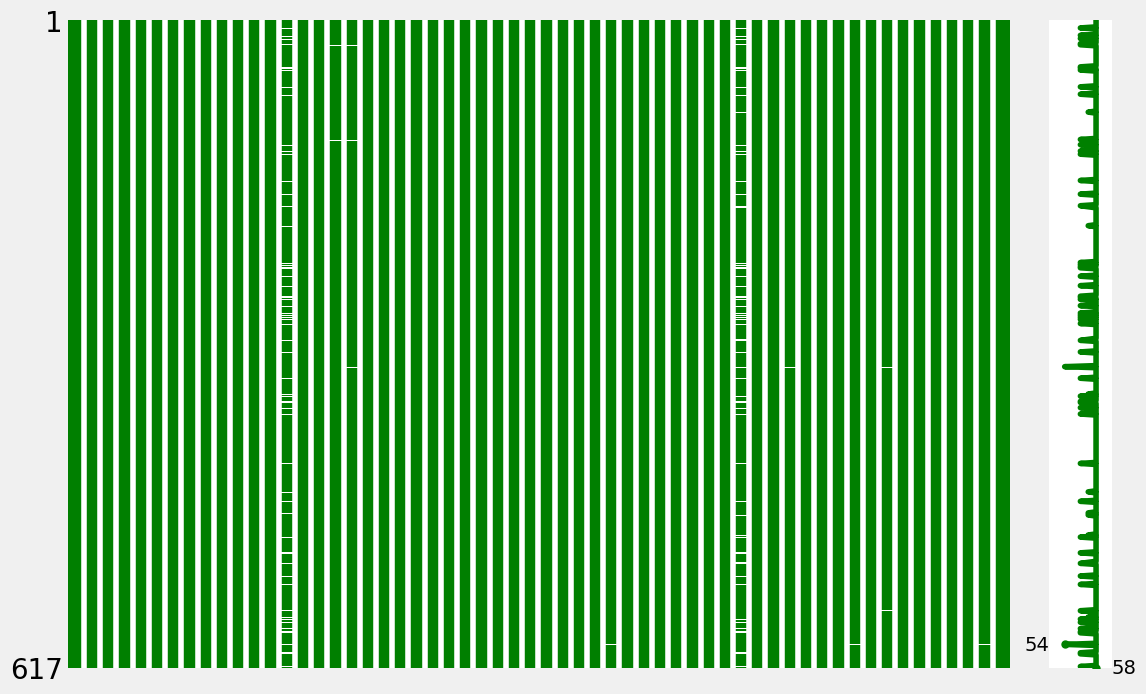

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(617, 58)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      61

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
AB,617,0.477,0.355,0.468,0.081,0.252,0.355,0.56,6.162,4.098832,27.029276
AF,617,3502.013,3120.319,2300.323,192.593,2197.345,3120.319,4361.637,28688.188,3.752050,31.223191
AH,617,118.625,85.2,127.839,85.2,85.2,85.2,113.74,1910.123,9.711921,112.529922
AM,617,38.969,20.533,69.728,3.178,12.27,20.533,39.14,630.518,6.459237,48.933404
AR,617,10.128,8.139,10.519,8.139,8.139,8.139,8.139,178.944,13.194688,195.288950
AX,617,5.546,5.032,2.552,0.7,4.128,5.032,6.432,38.271,4.991457,55.187019
AY,617,0.06,0.026,0.417,0.026,0.026,0.026,0.037,10.316,22.828869,526.639960
AZ,617,10.566,10.461,4.351,3.397,8.13,10.461,12.97,38.972,0.770253,3.528935
BC,617,8.053,1.23,65.167,1.23,1.23,1.23,5.081,1463.693,18.550006,369.913990
BD,617,5350.389,4997.961,3021.327,1693.624,4155.703,4997.961,6035.886,53060.599,10.190256,135.774276


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



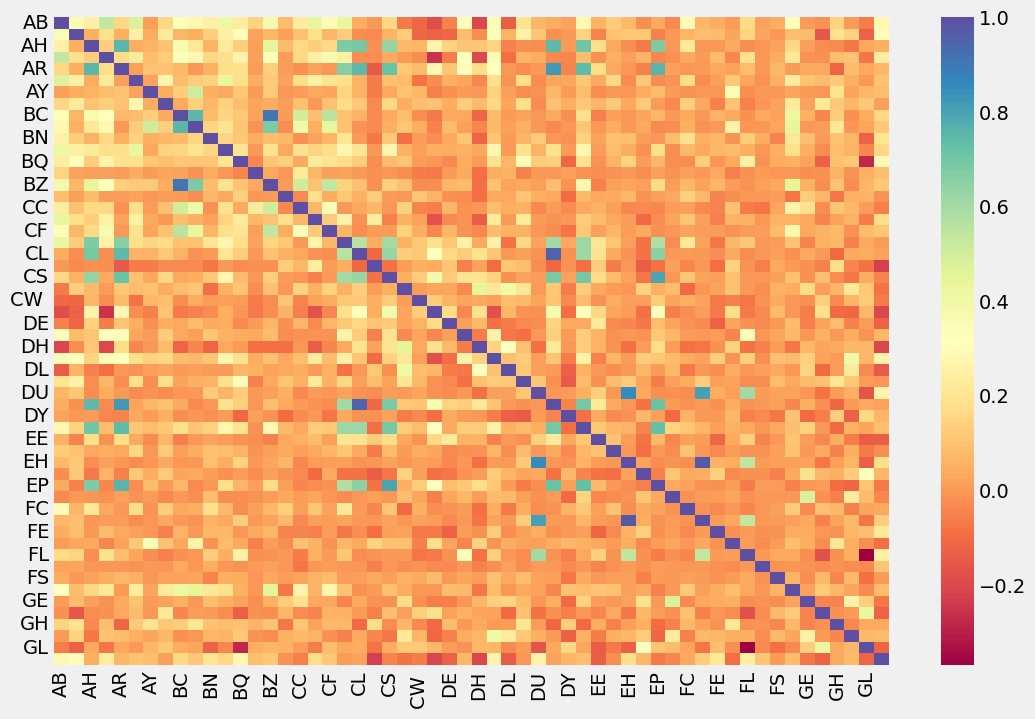

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



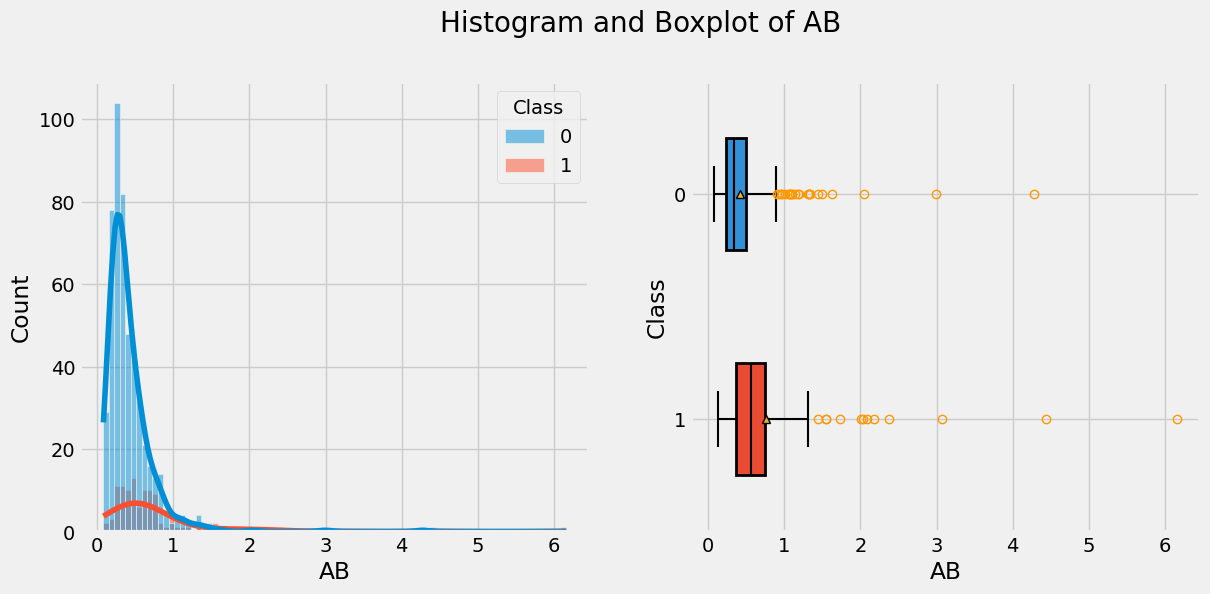

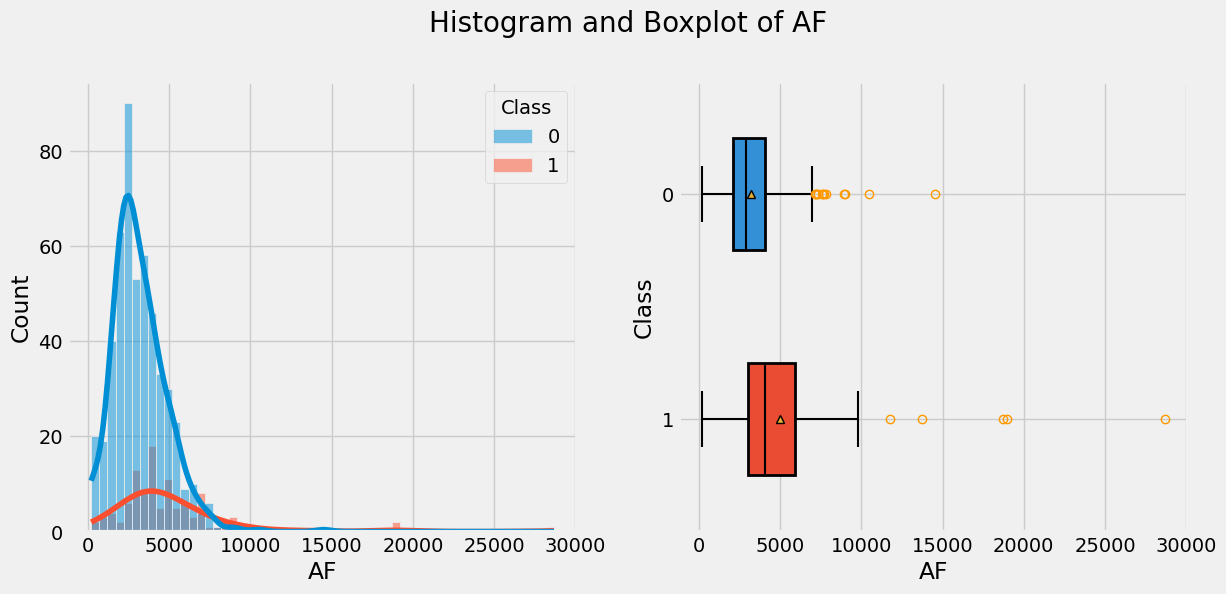

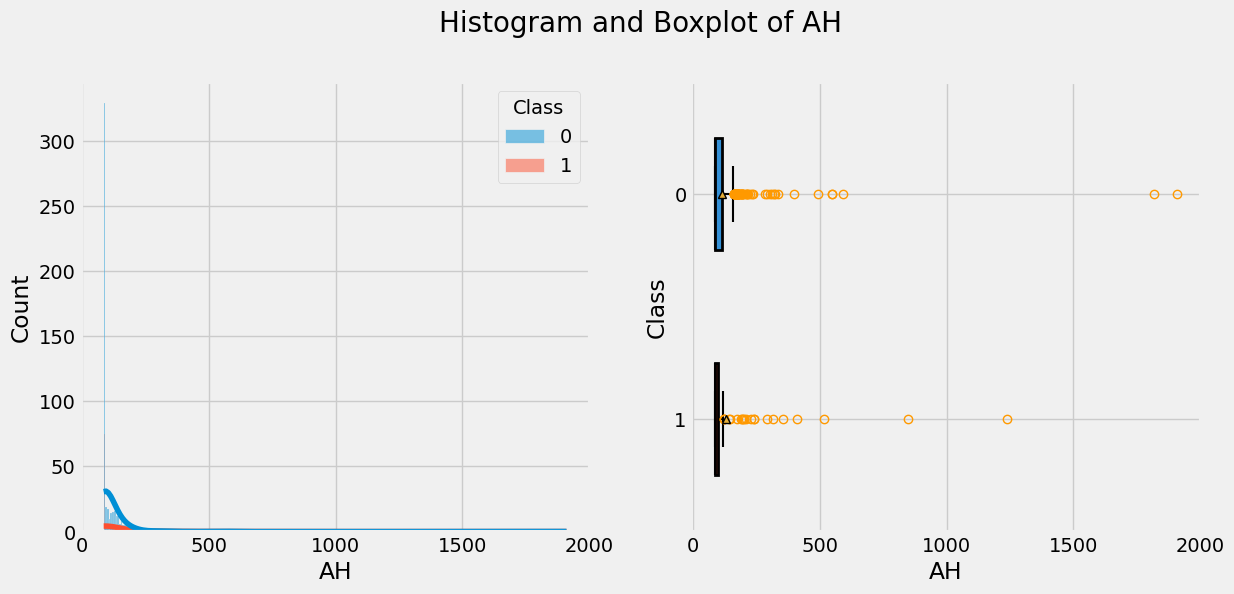

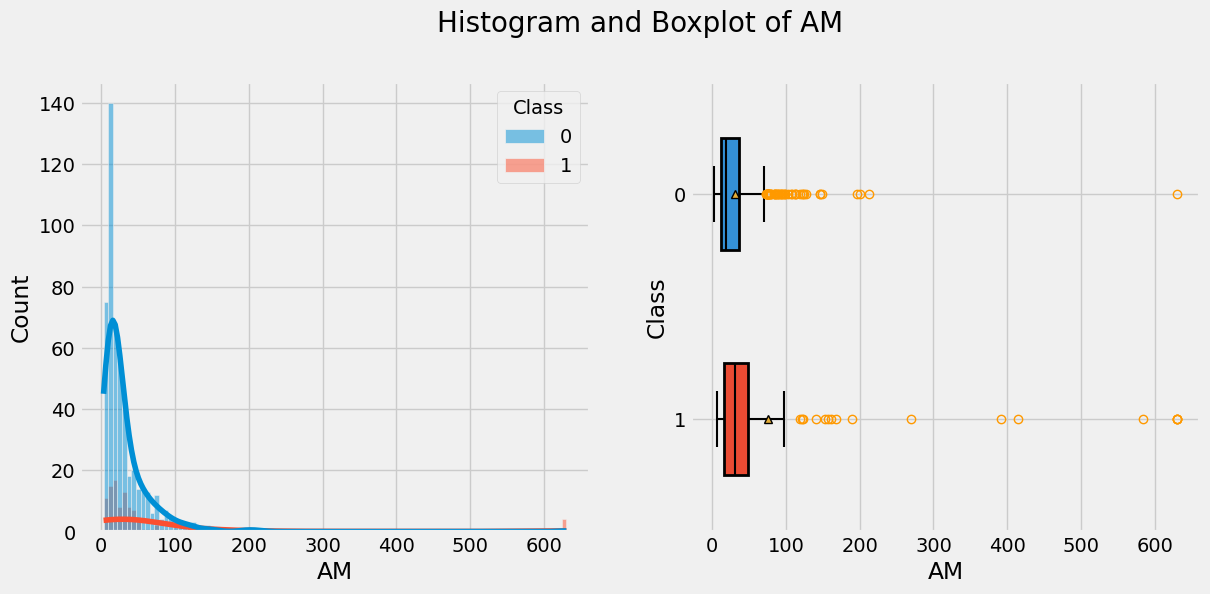

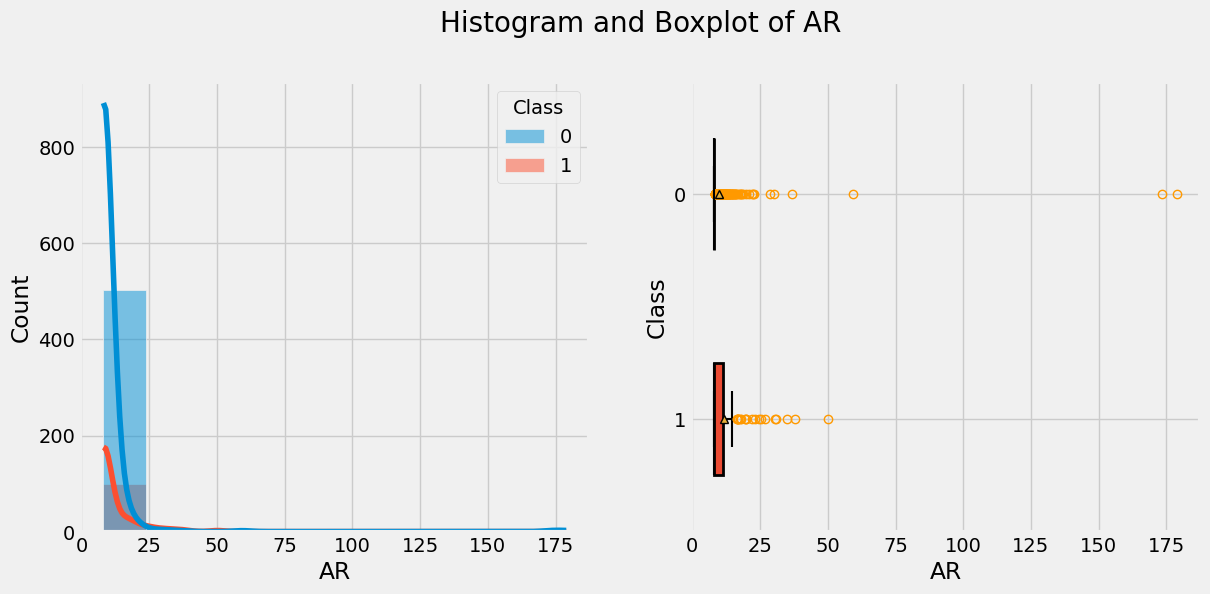

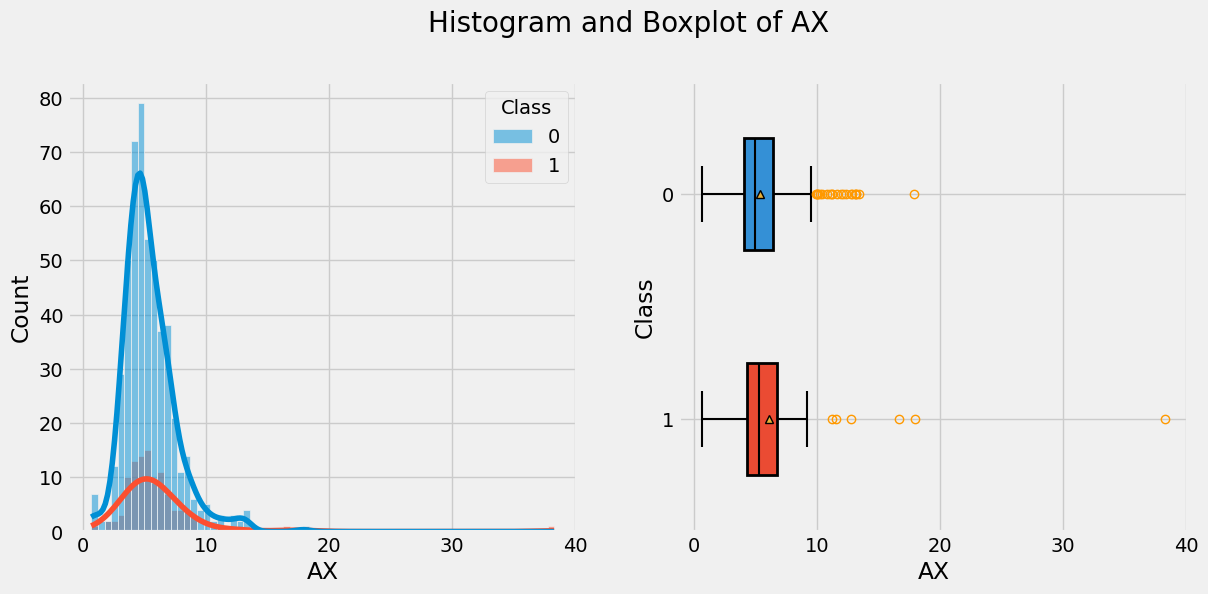

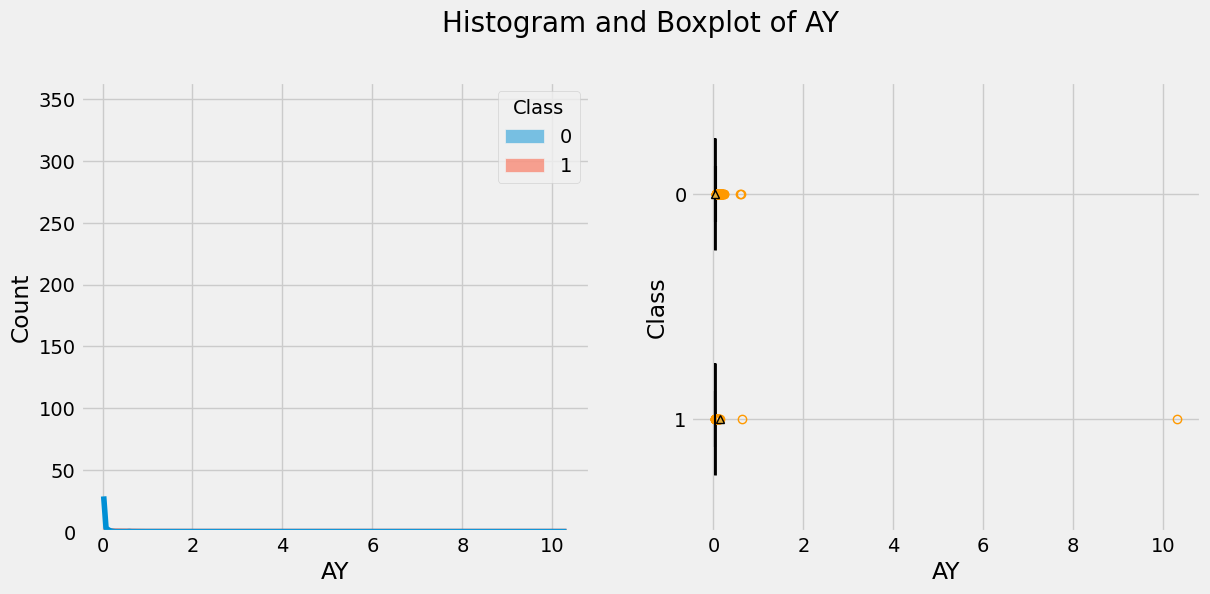

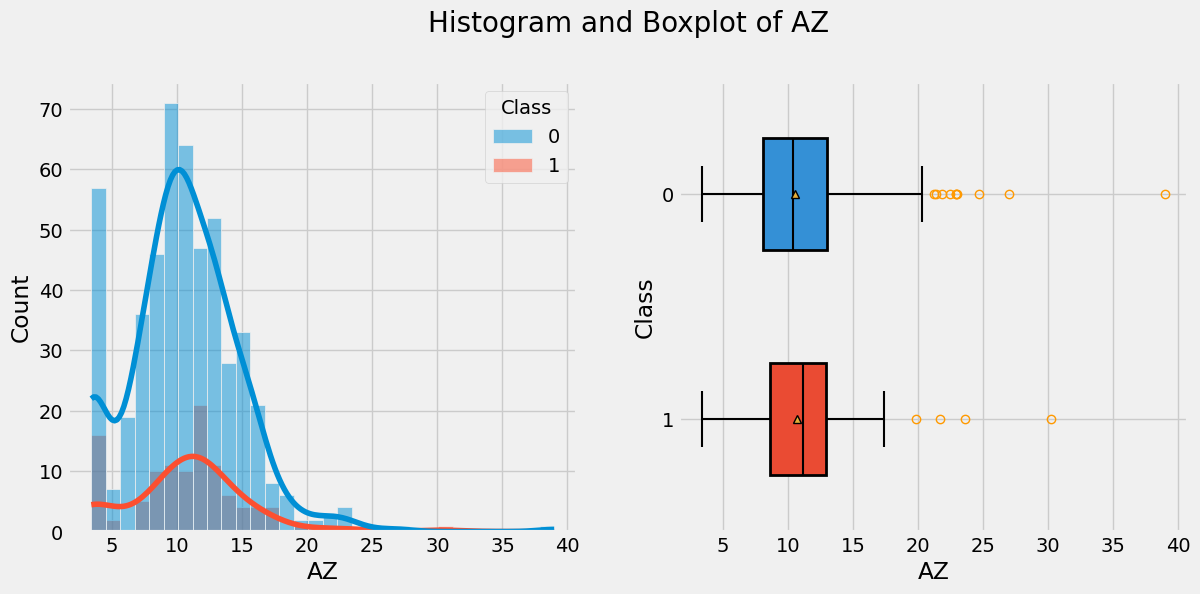

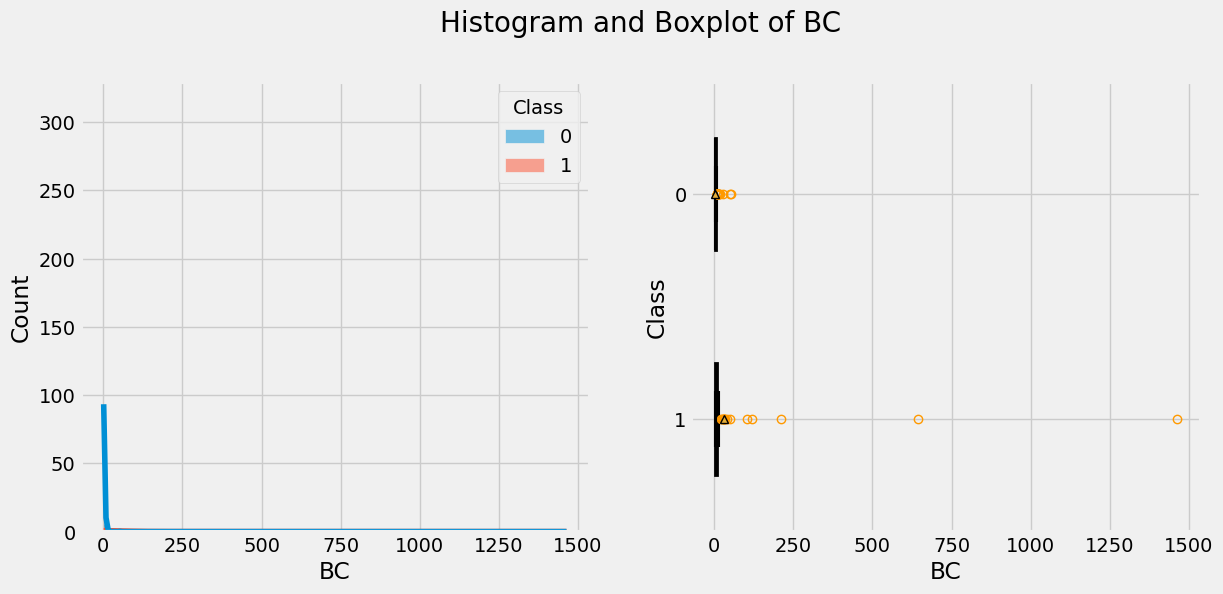

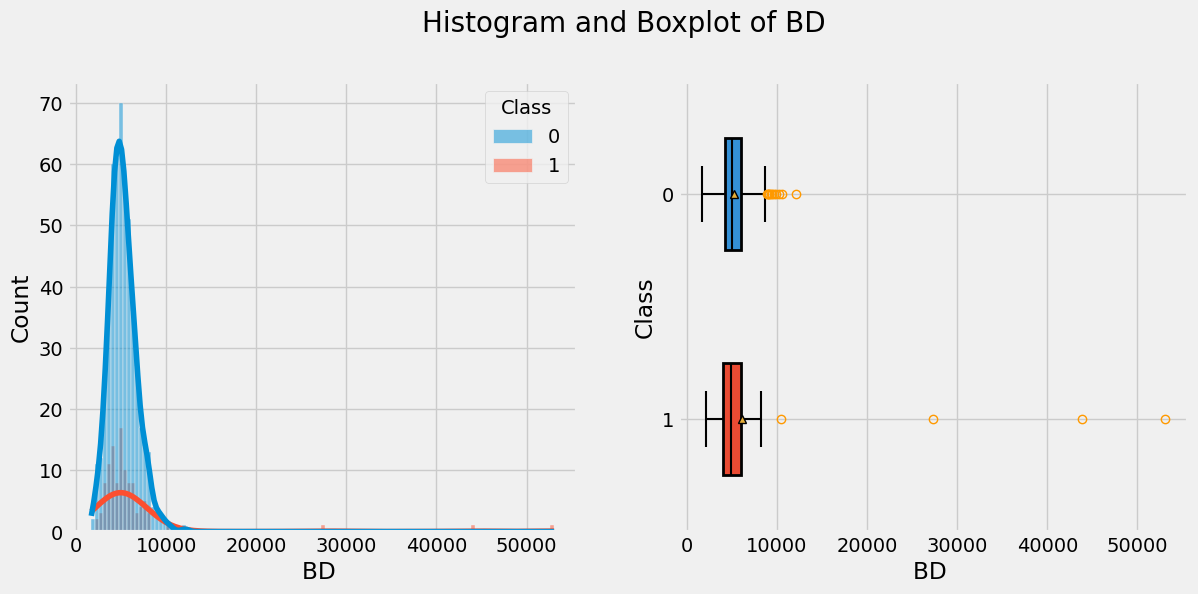

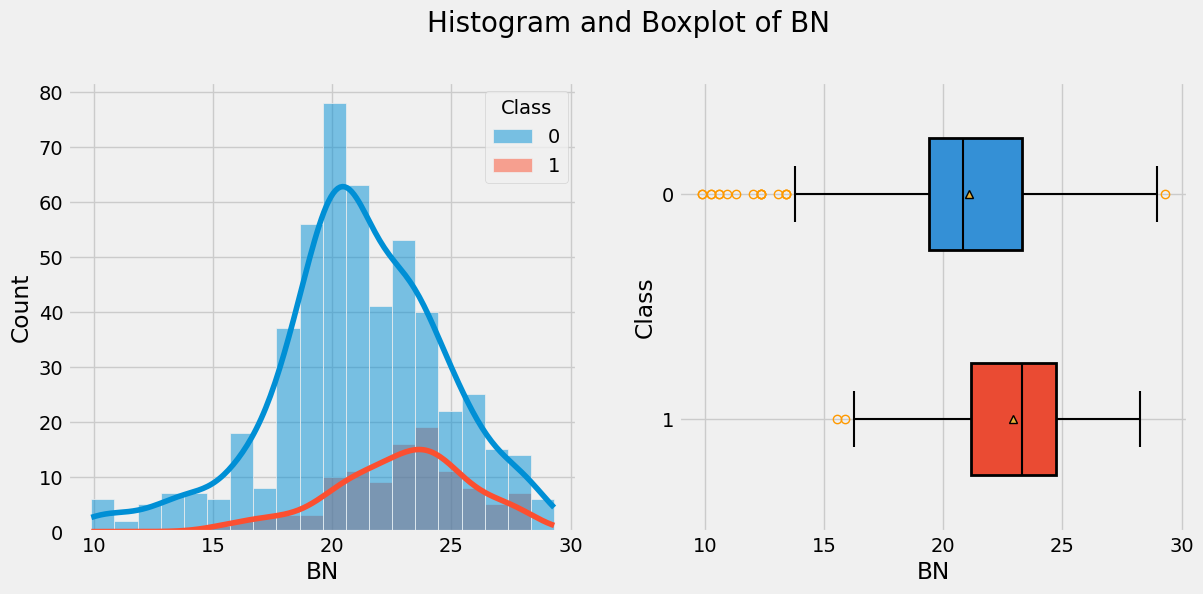

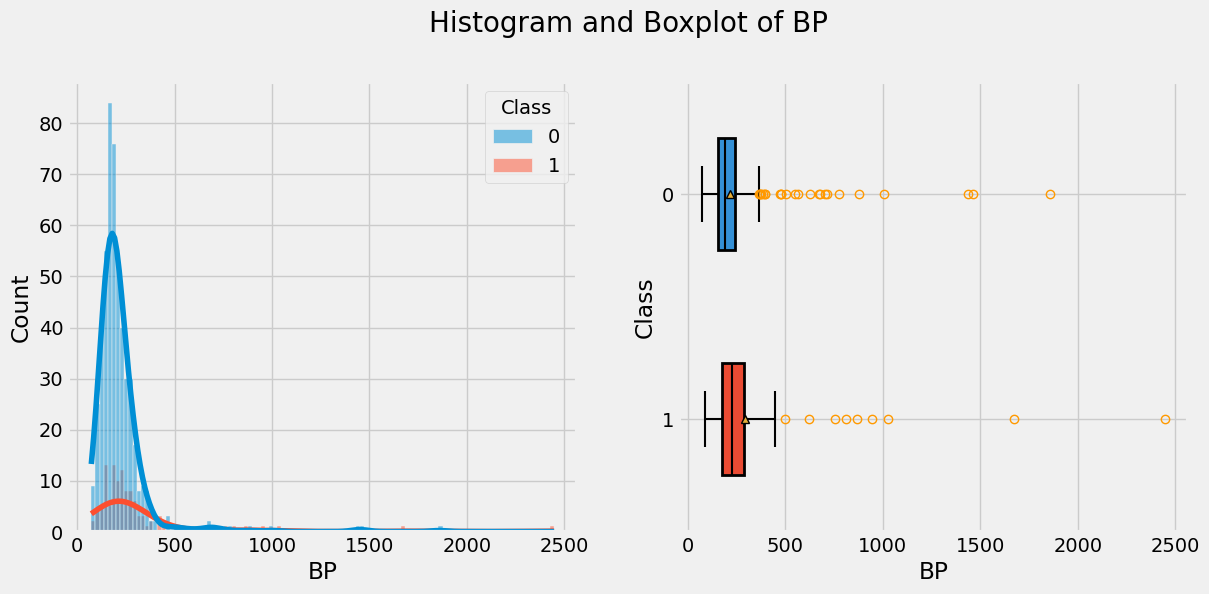

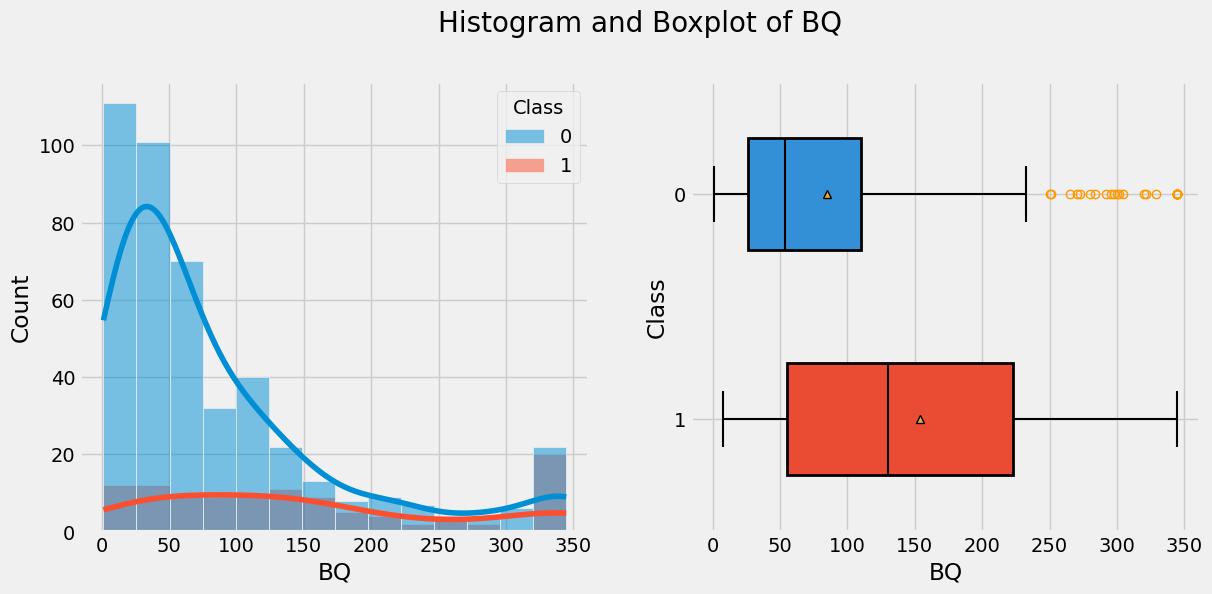

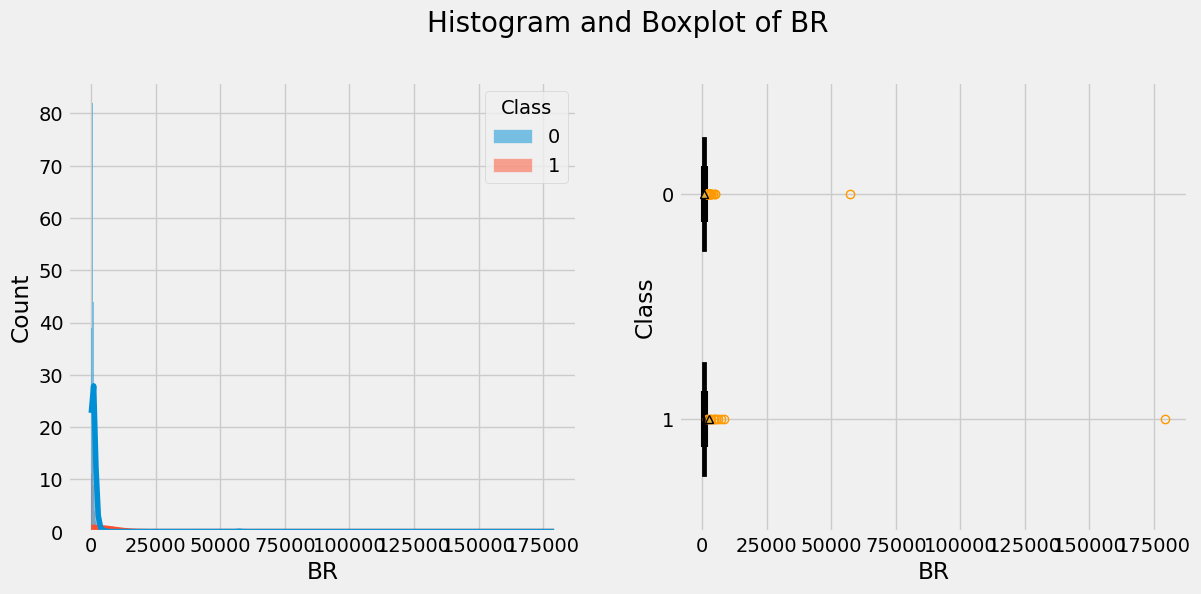

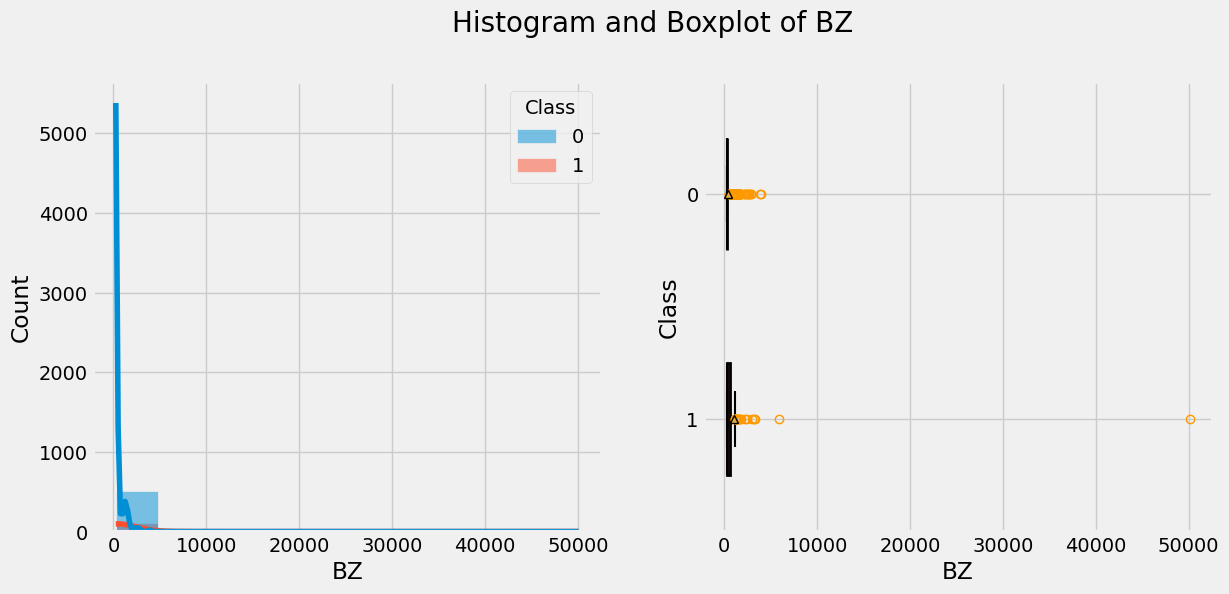

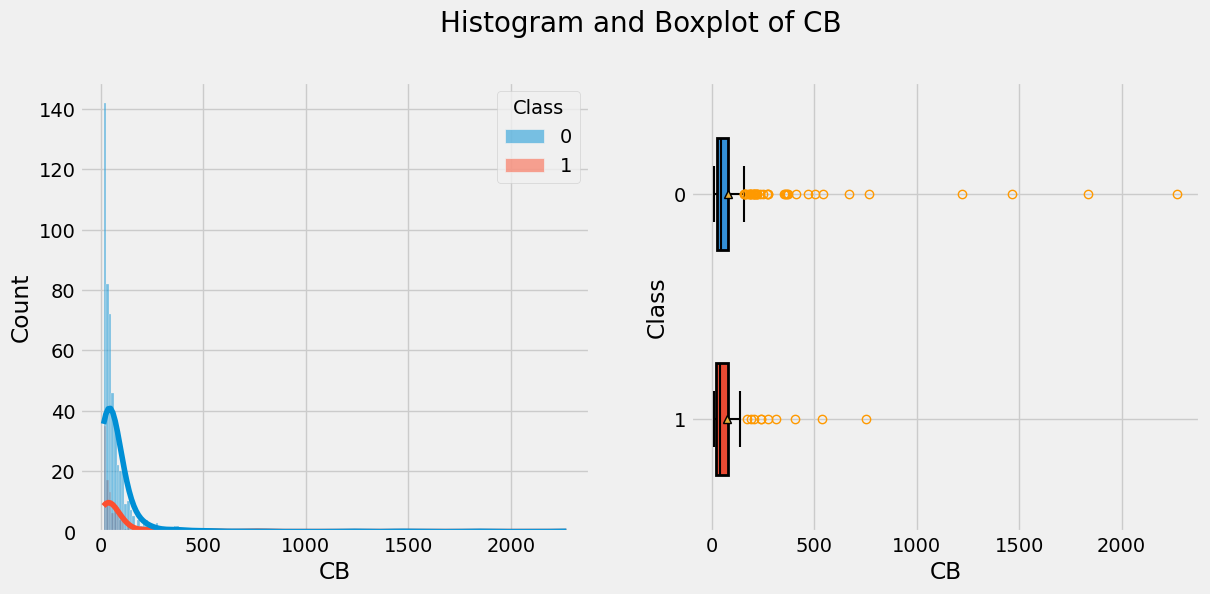

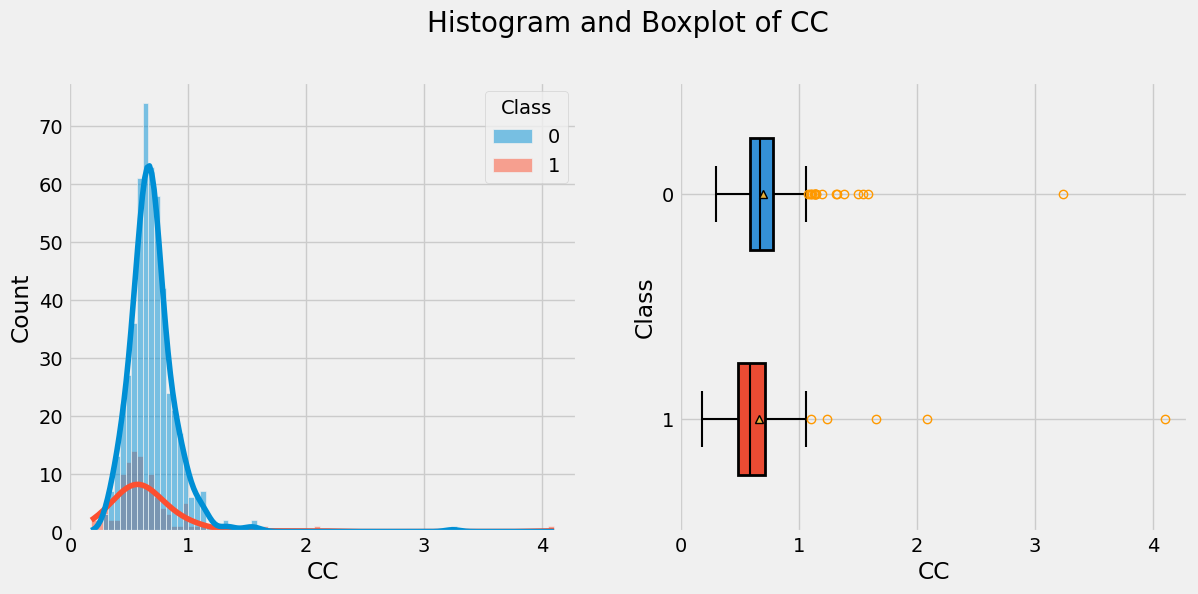

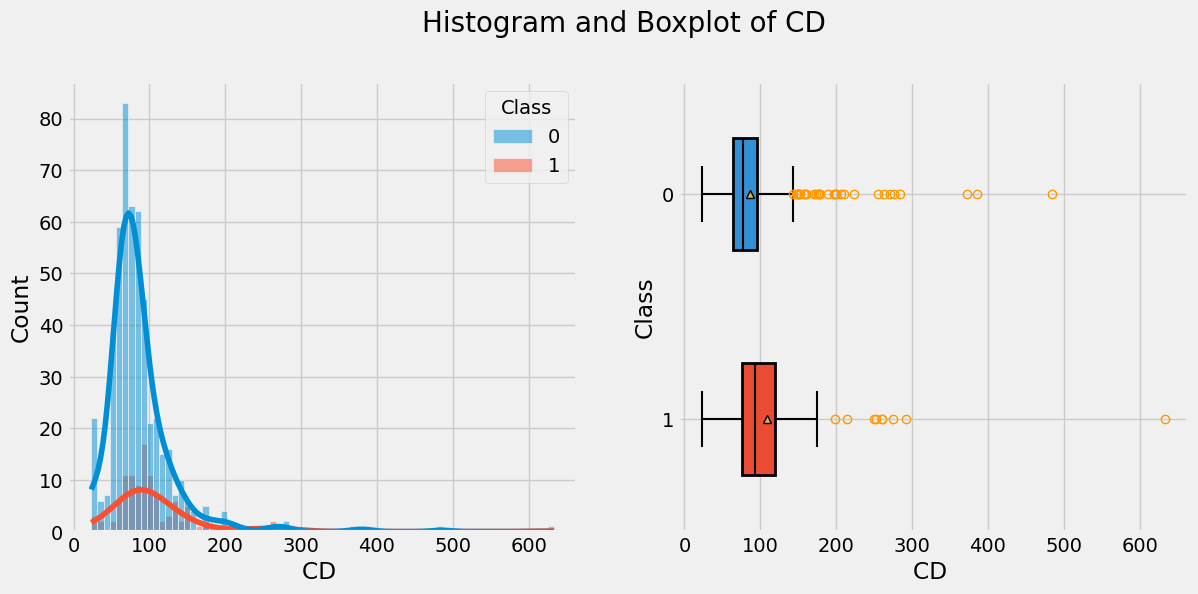

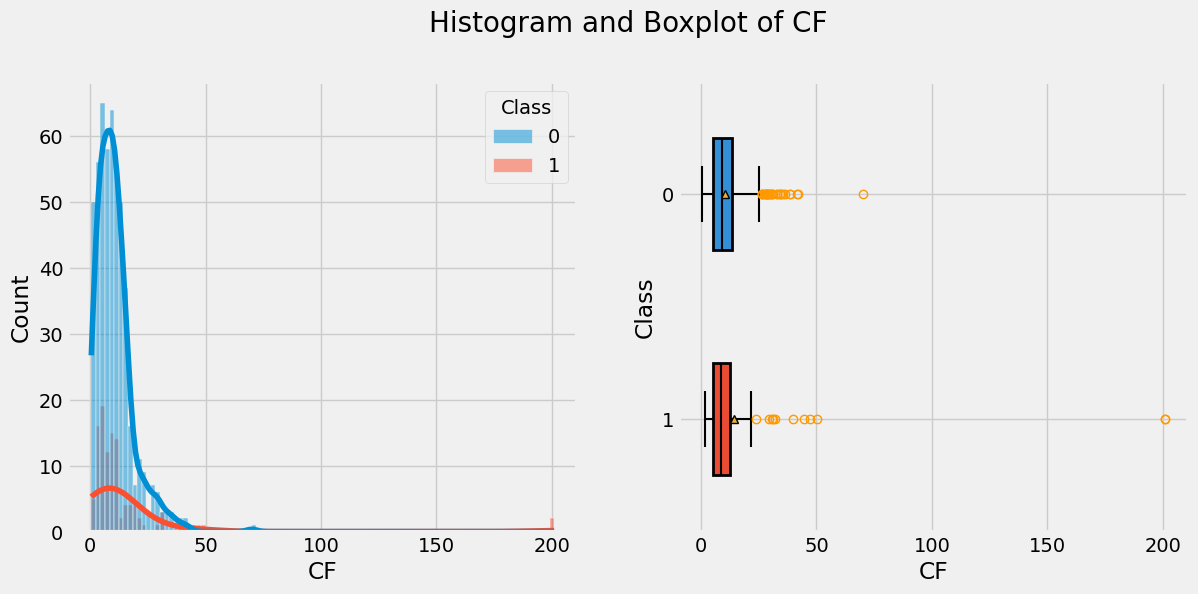

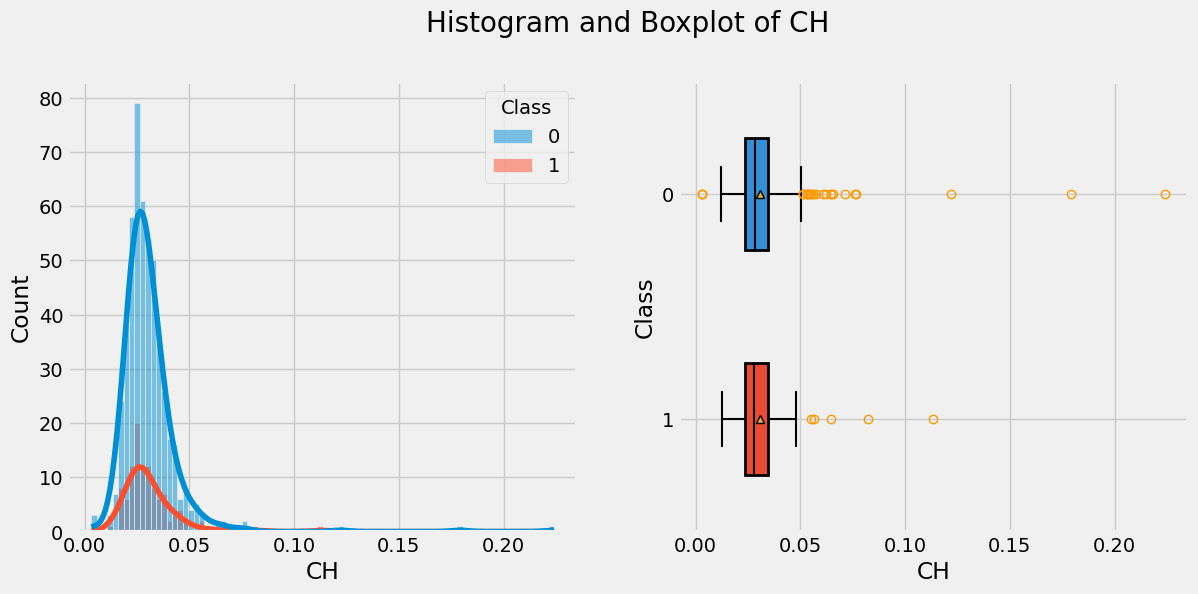

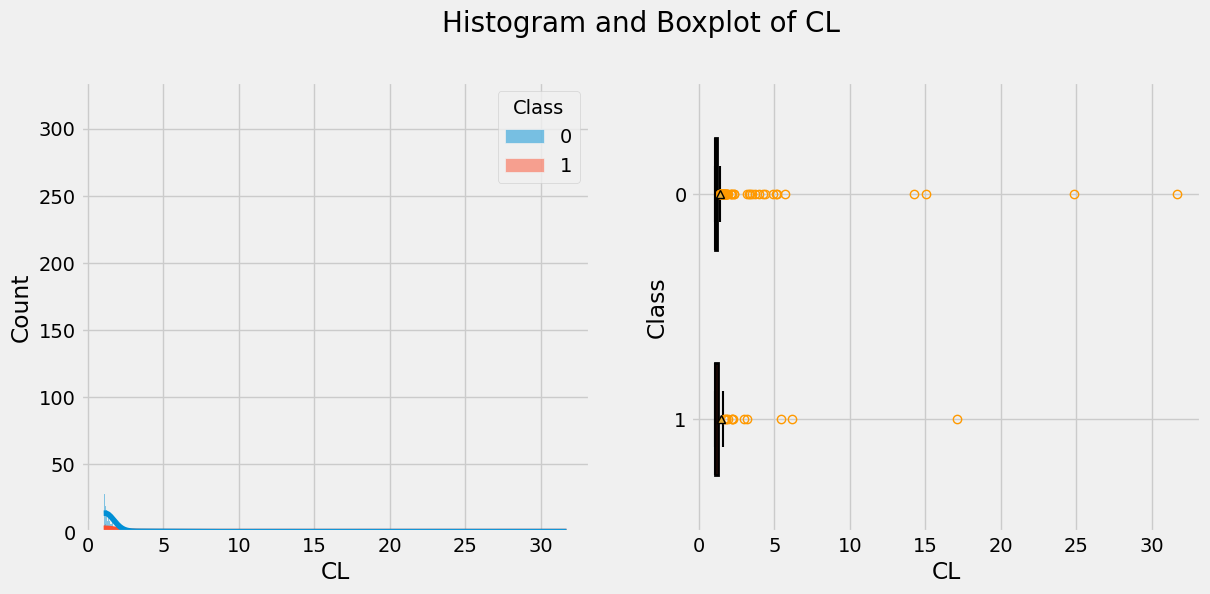

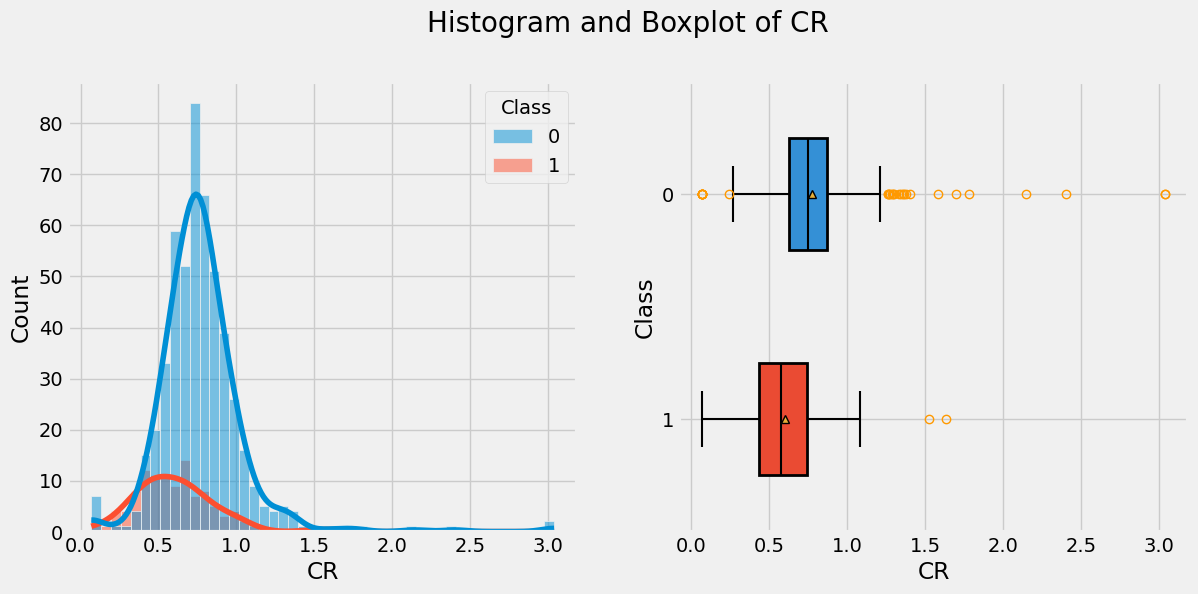

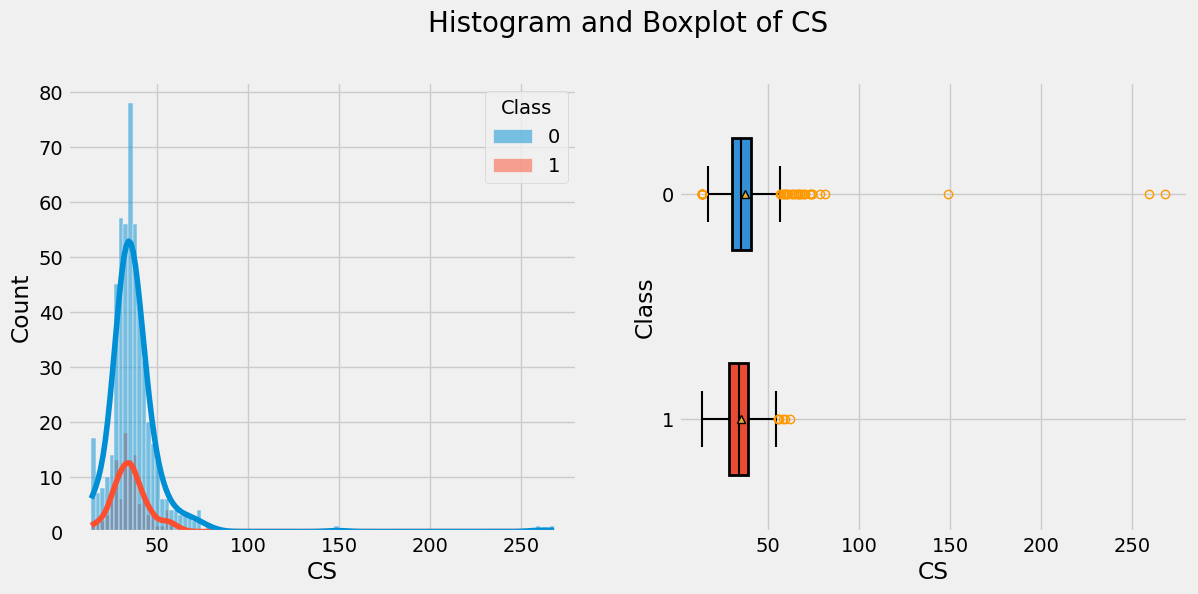

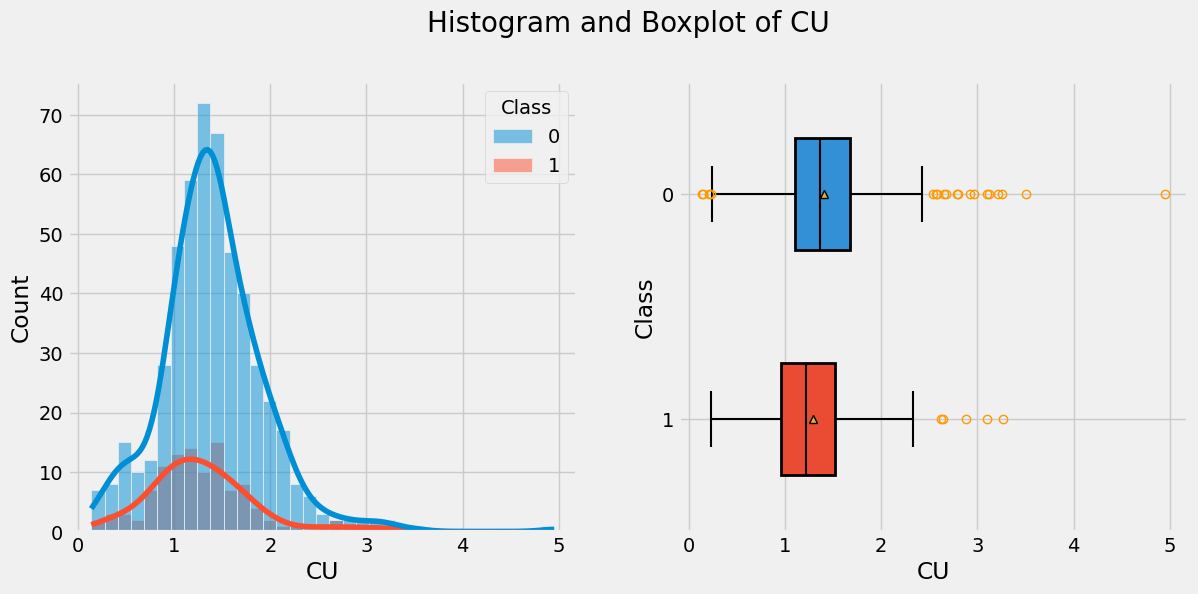

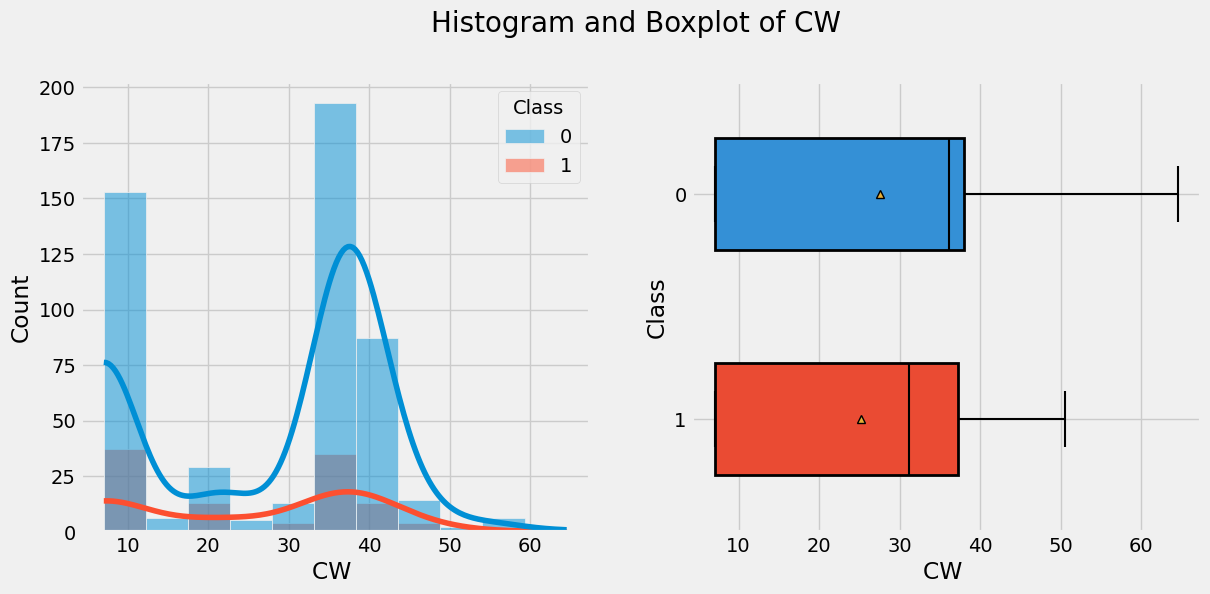

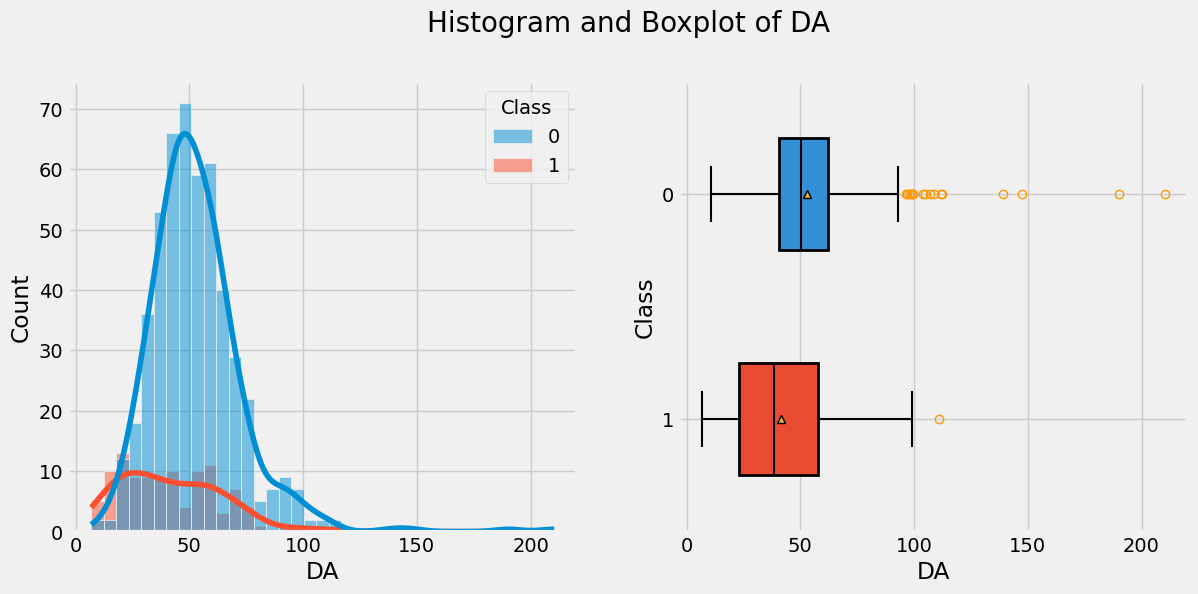

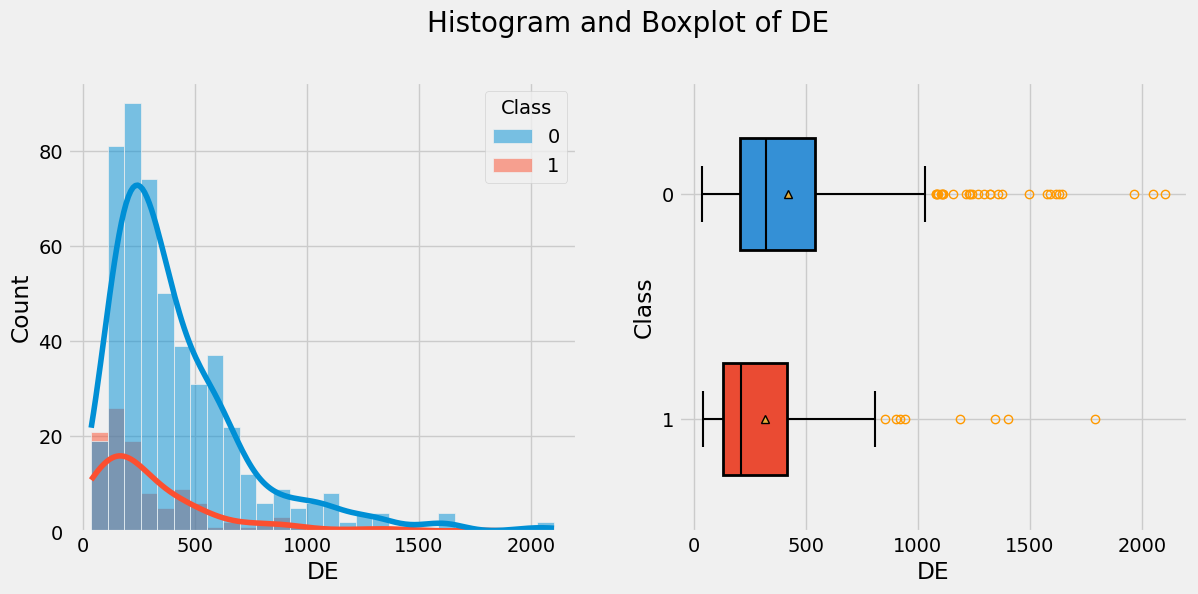

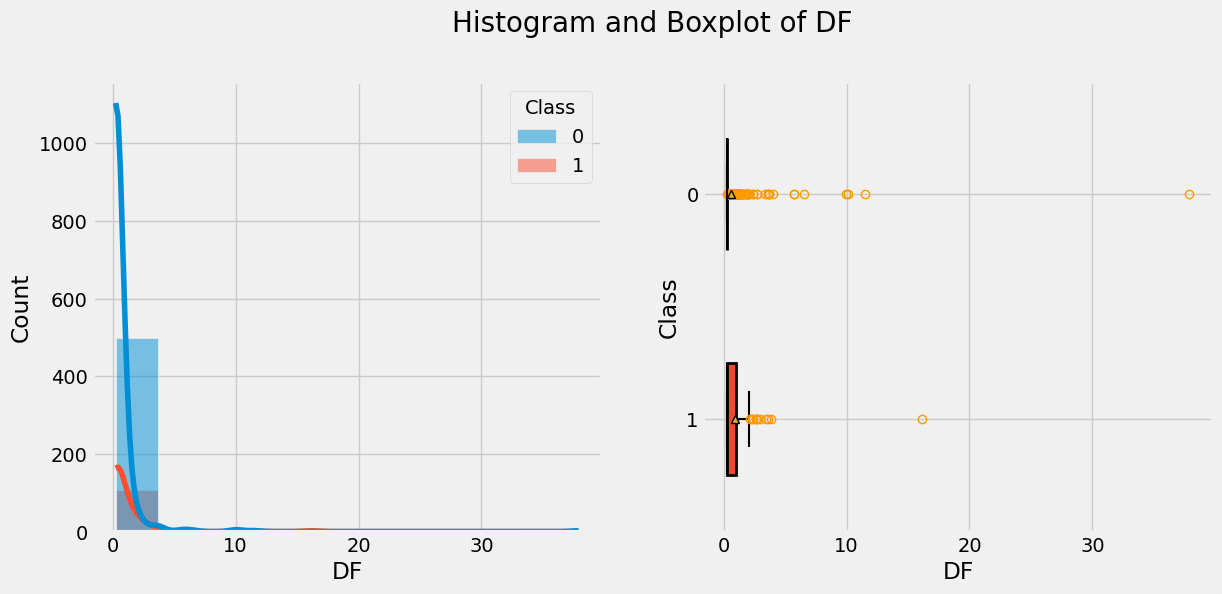

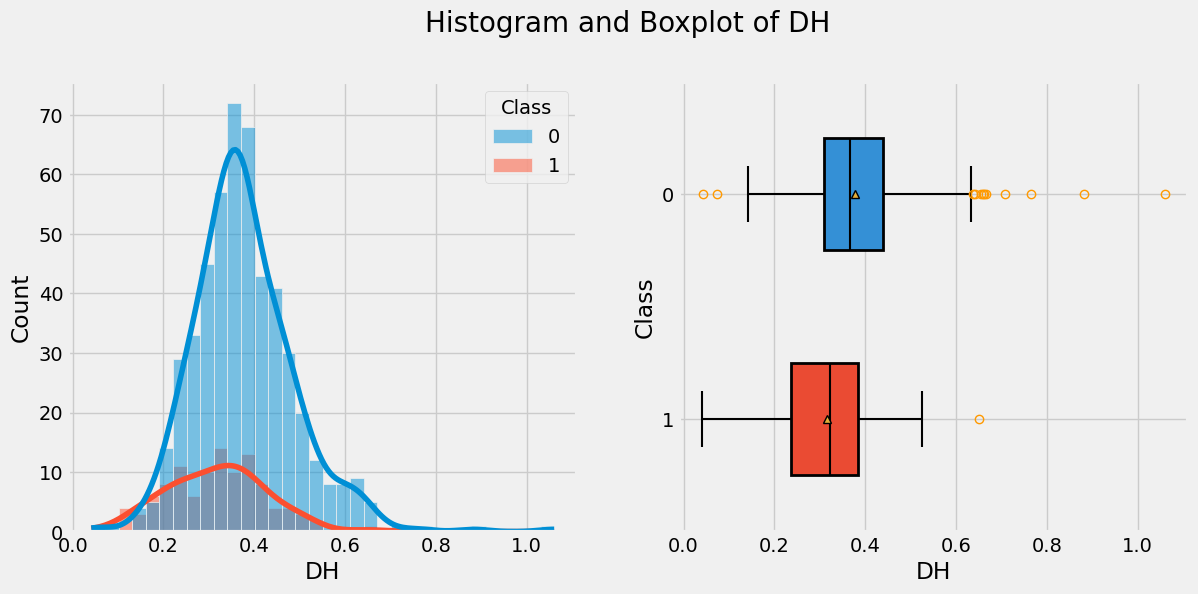

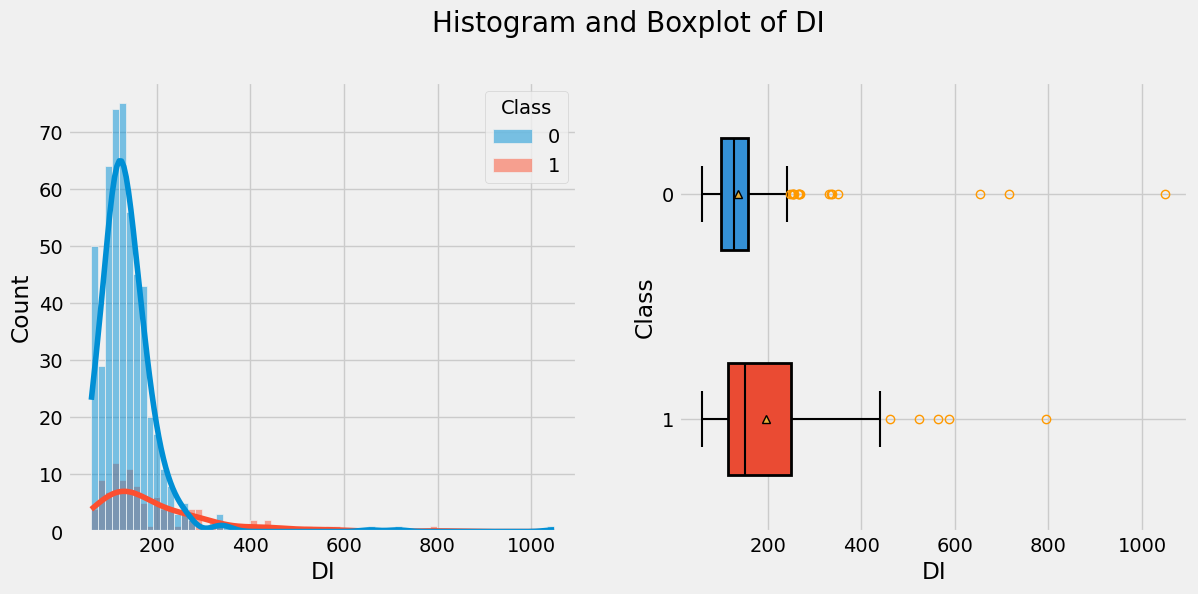

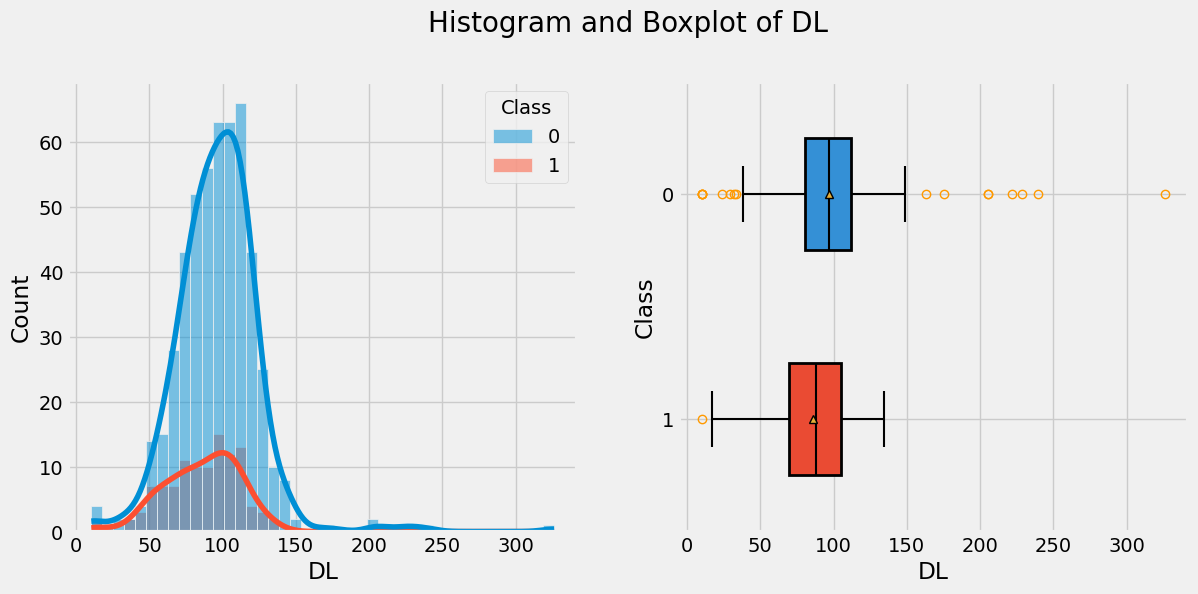

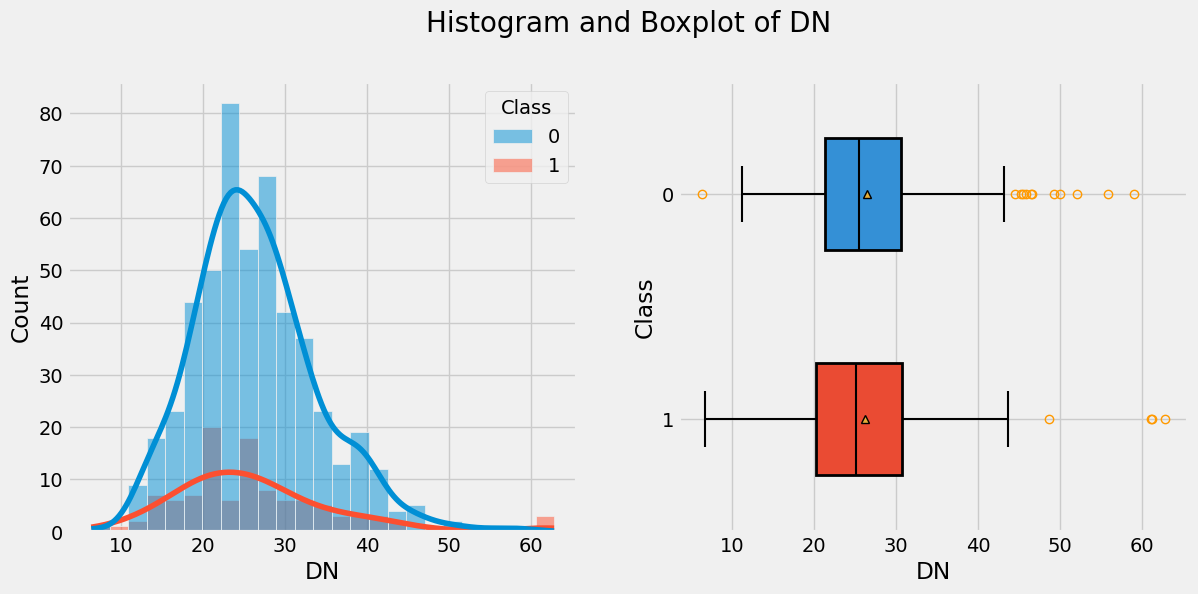

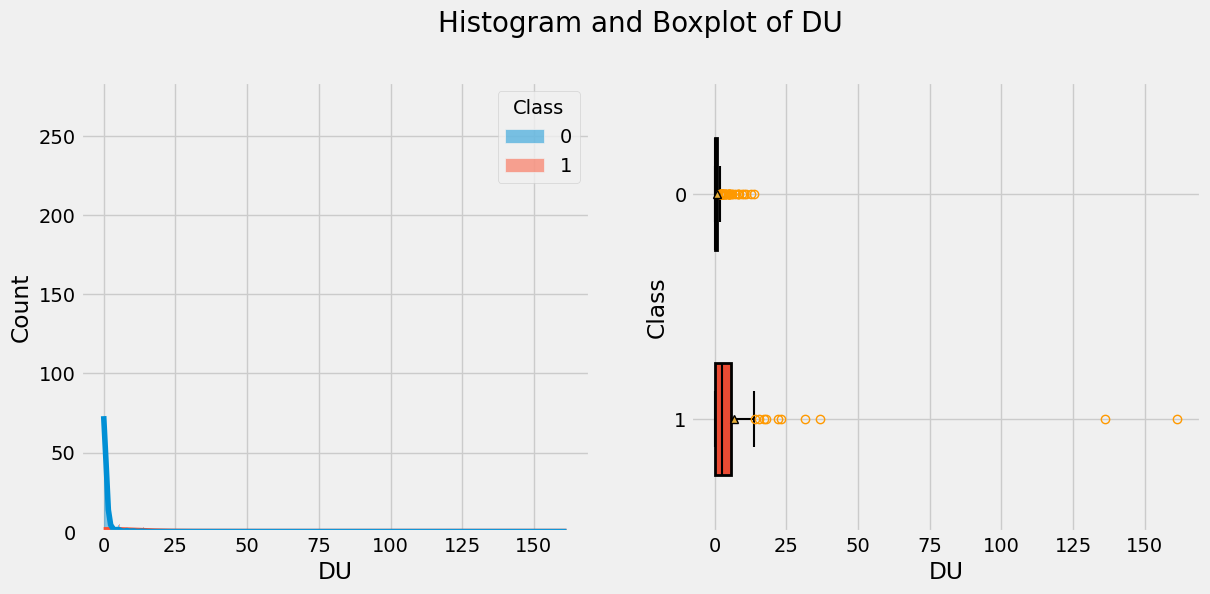

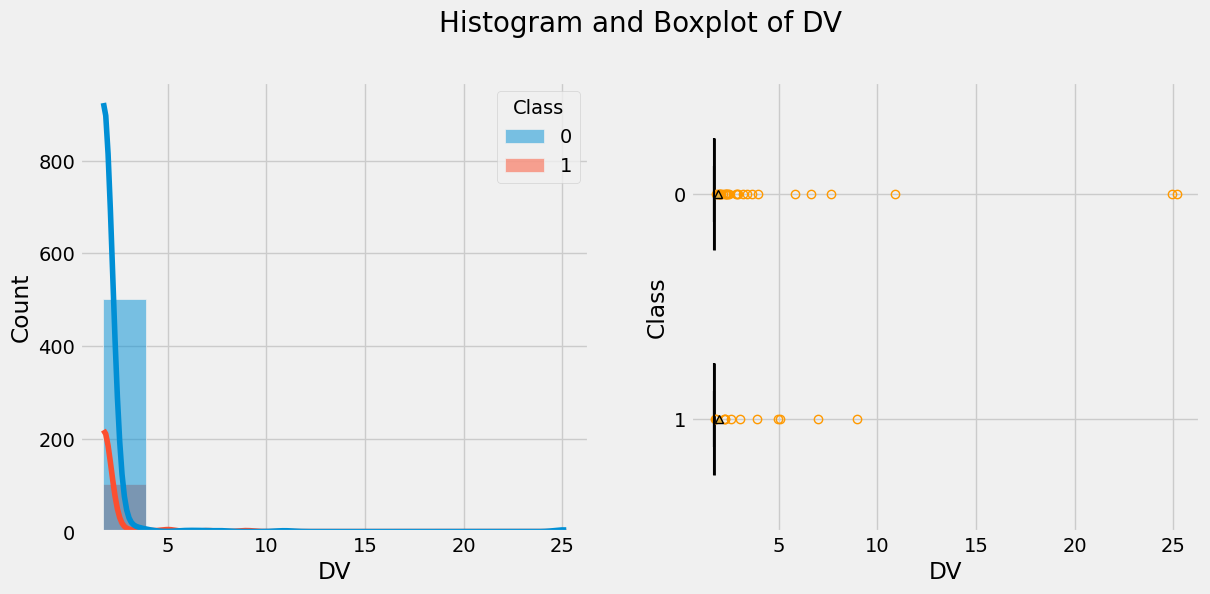

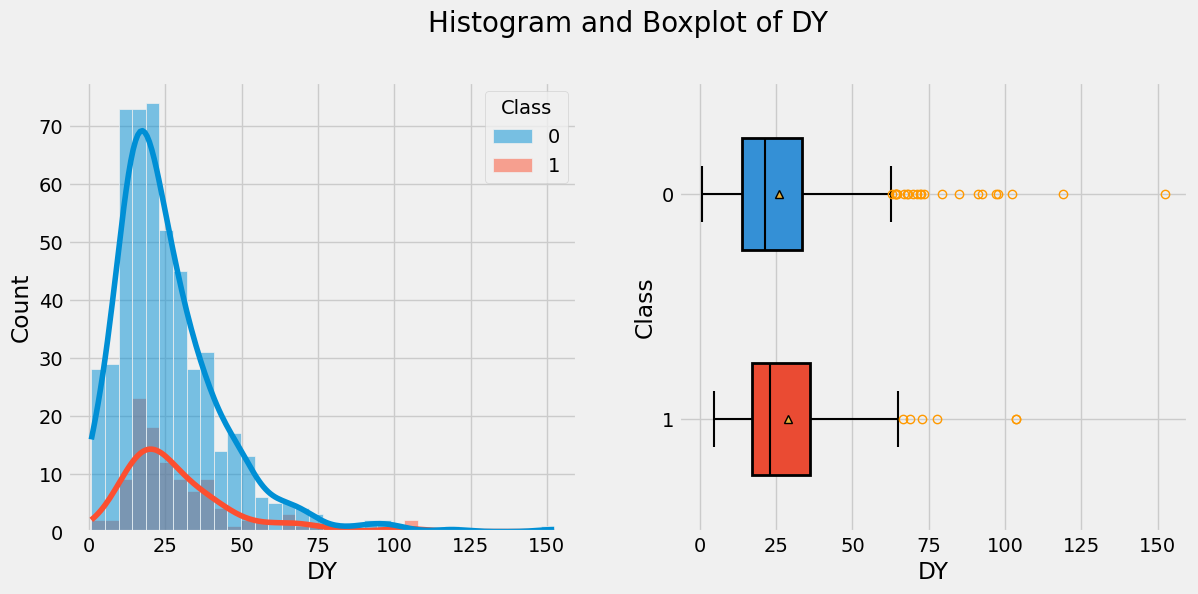

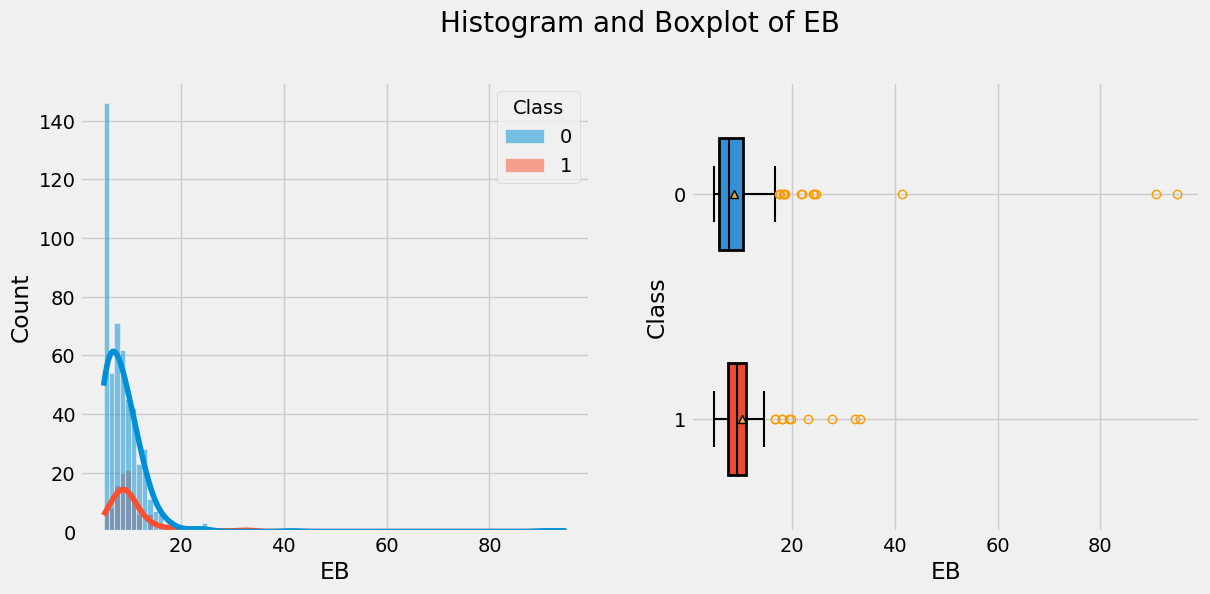

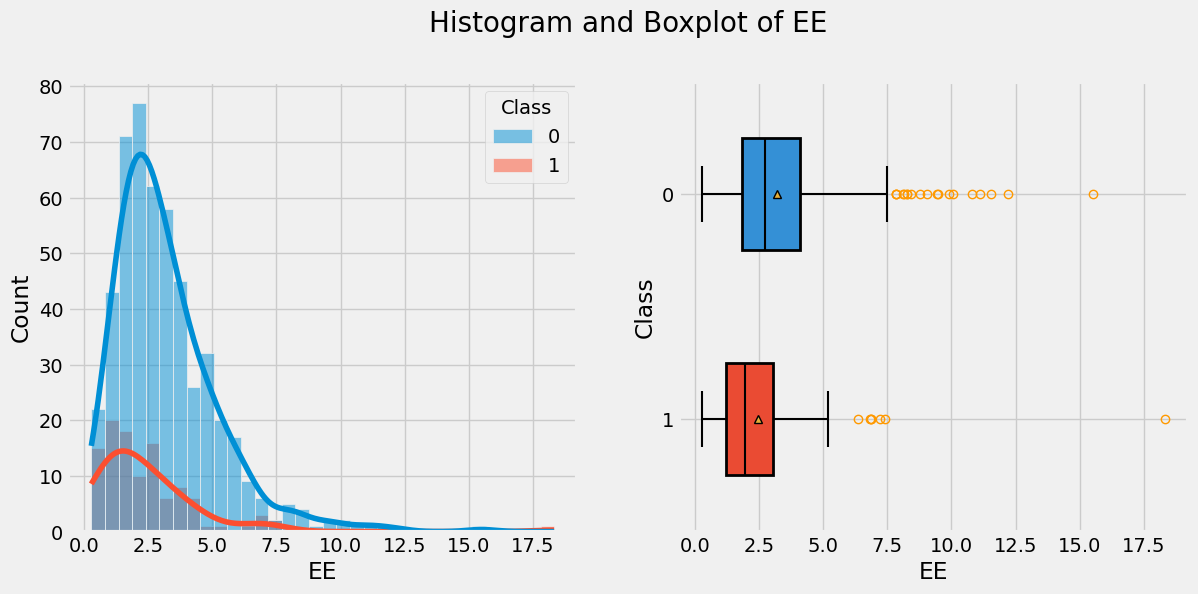

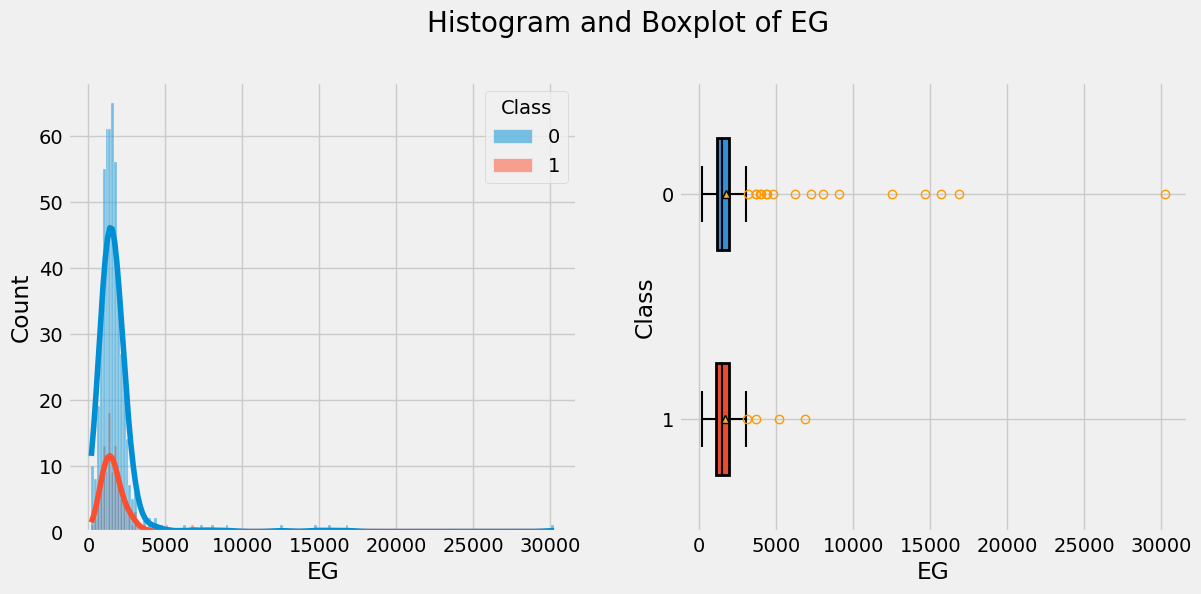

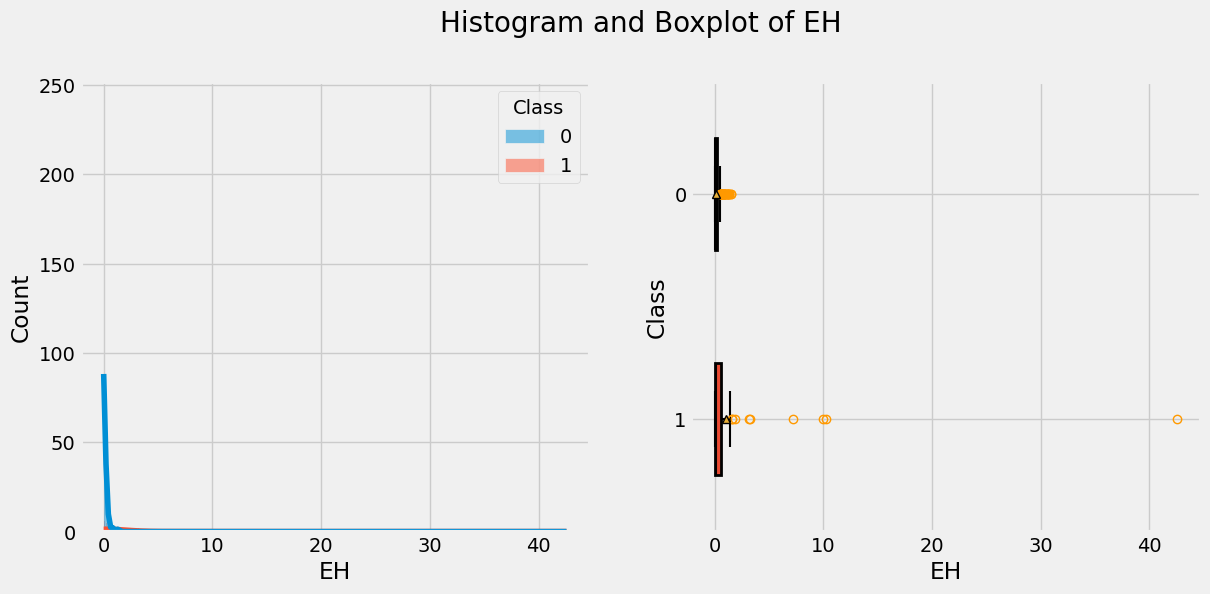

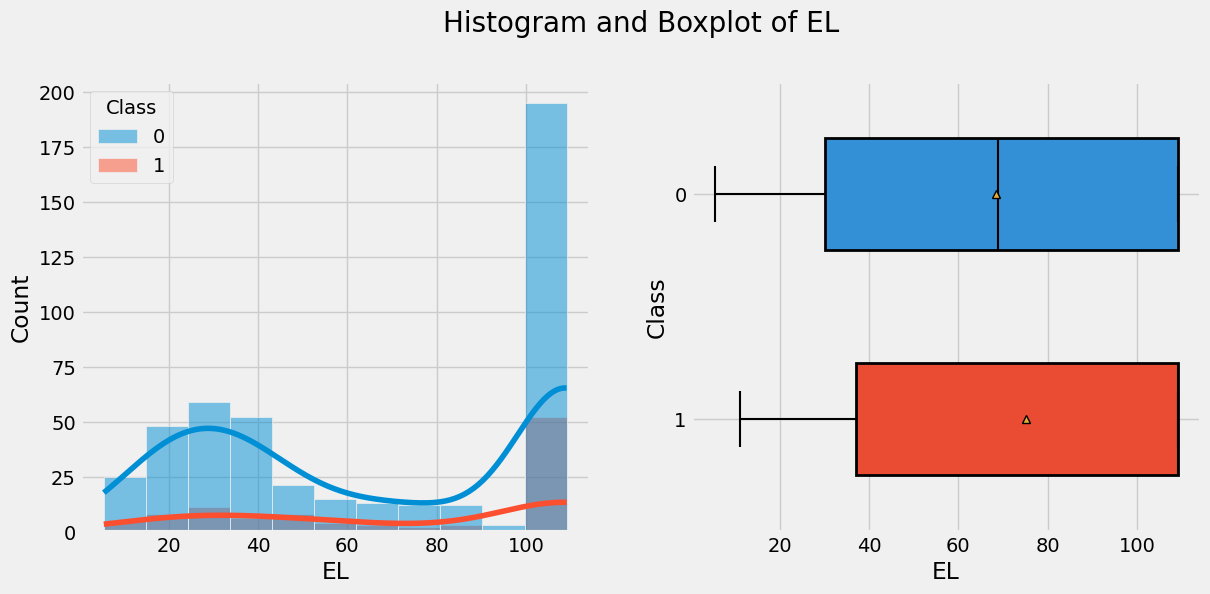

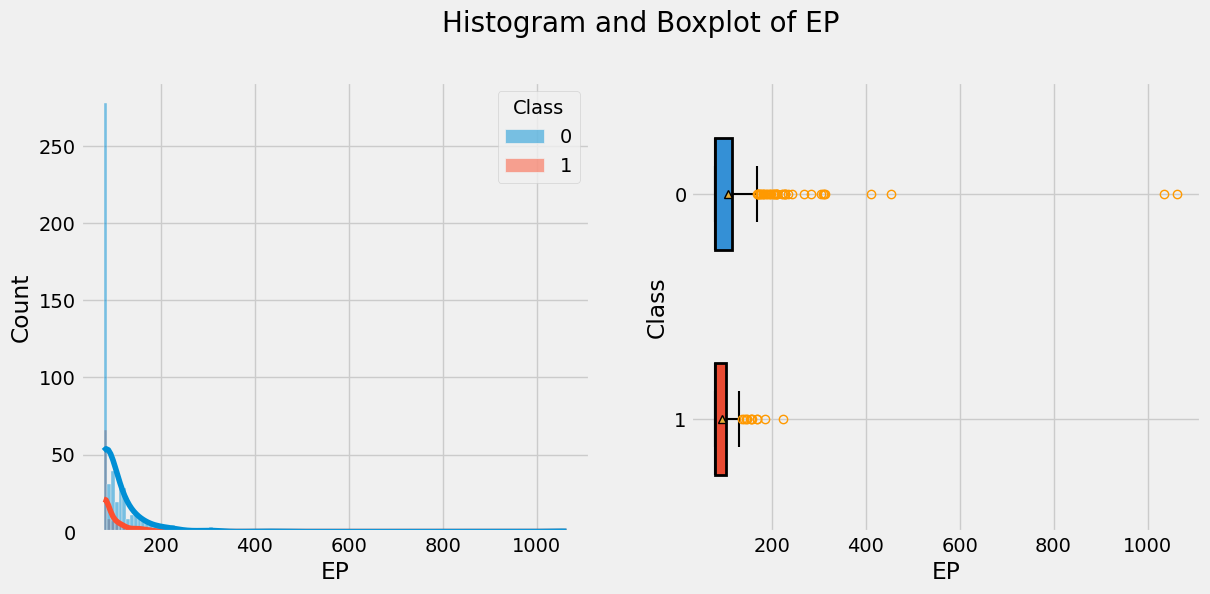

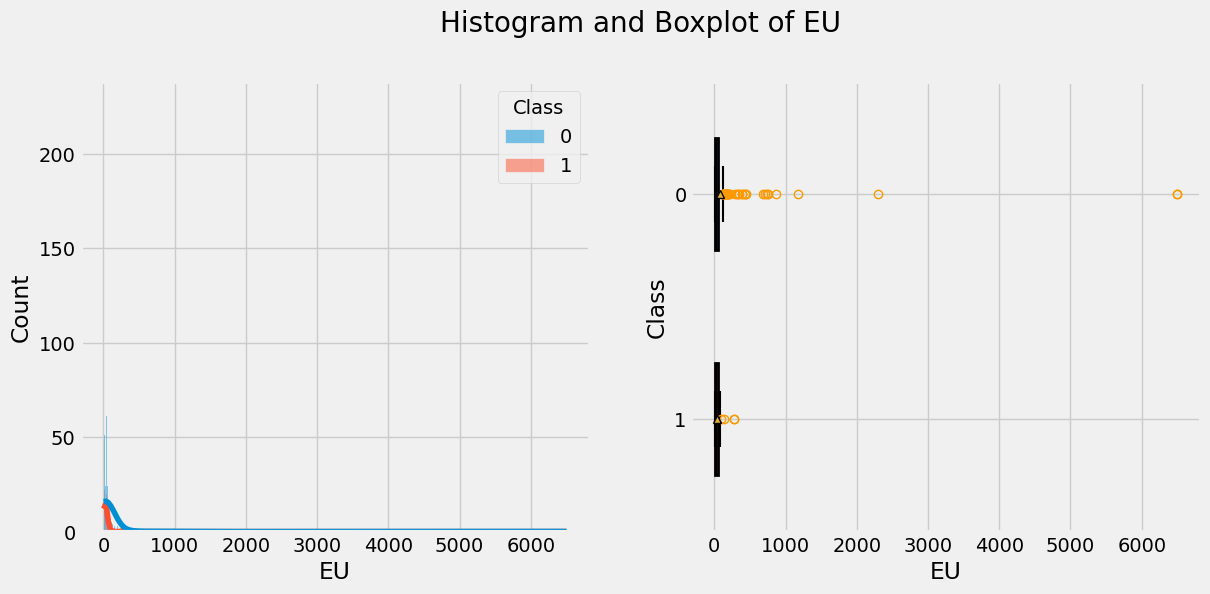

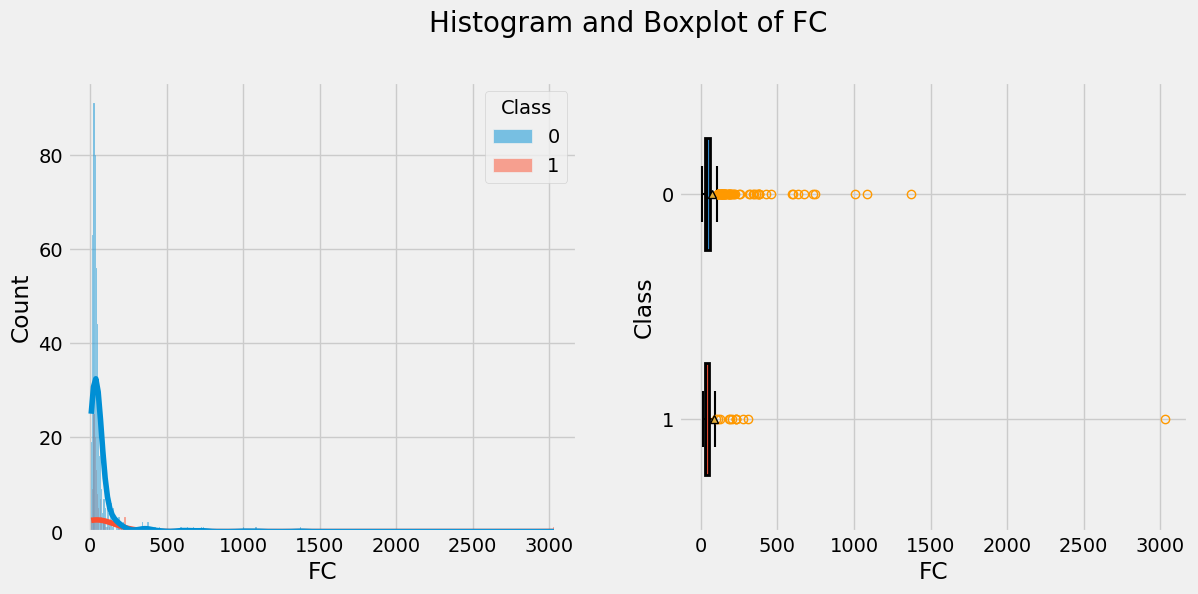

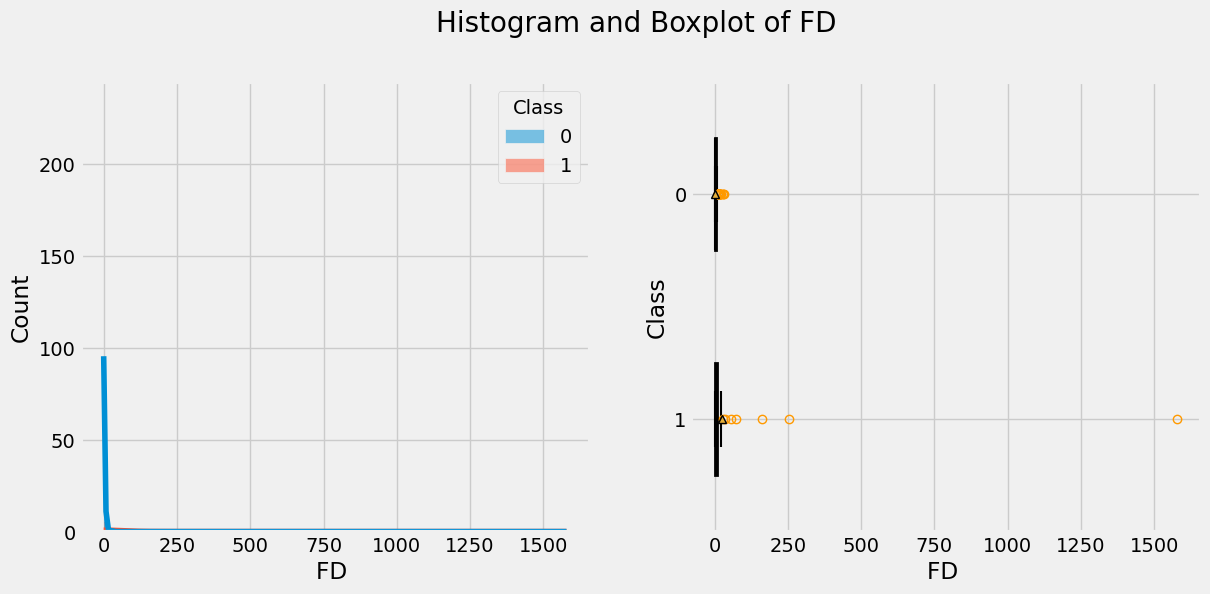

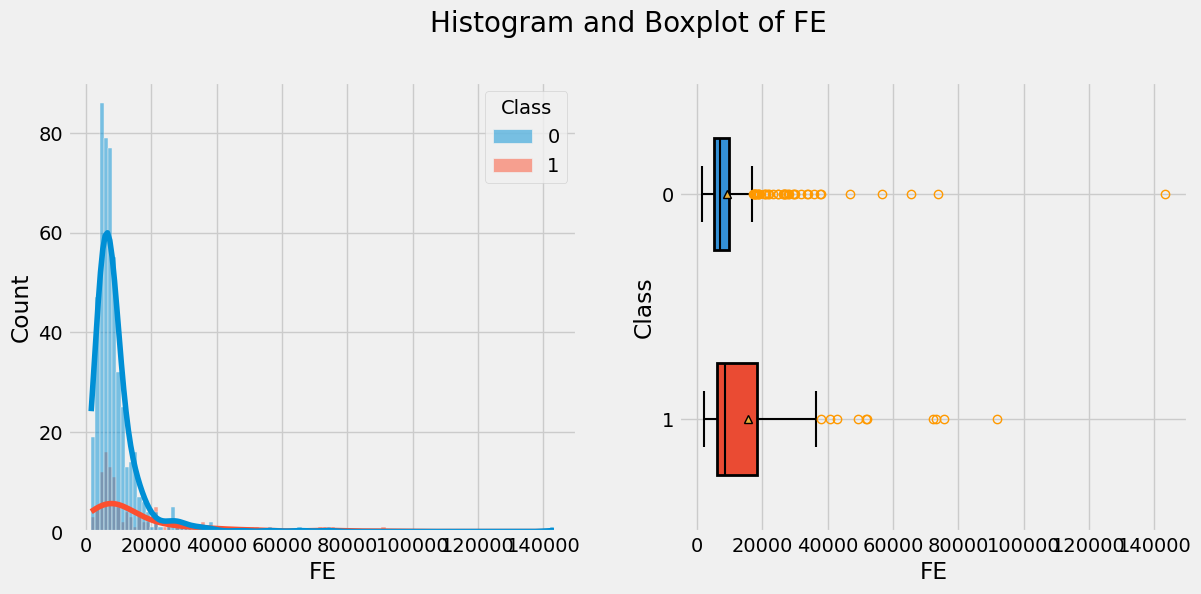

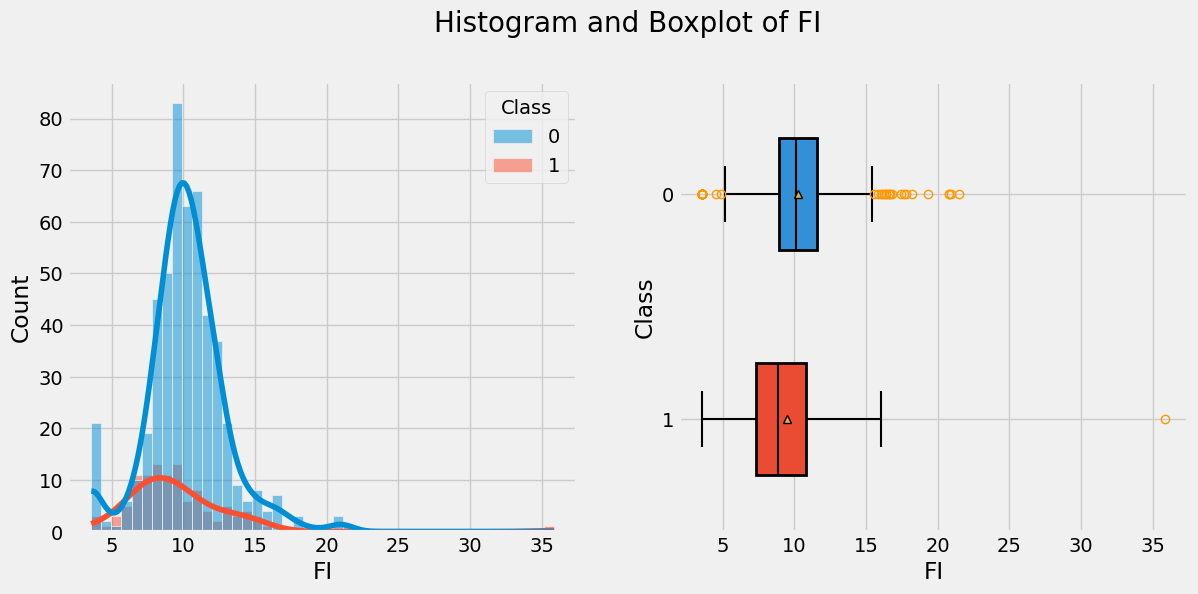

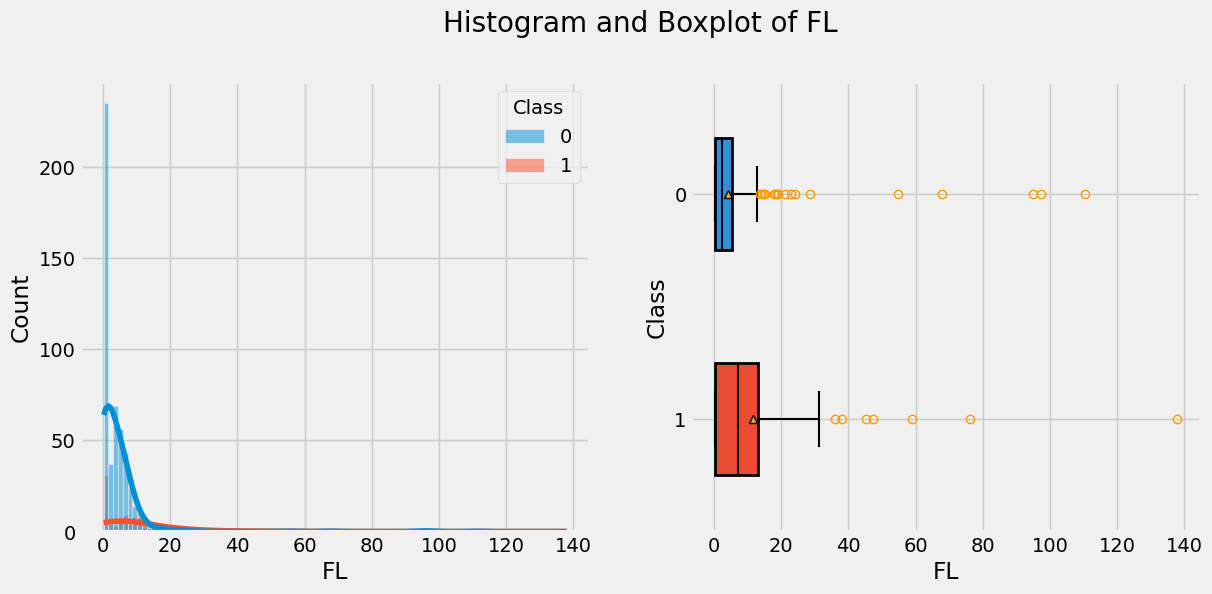

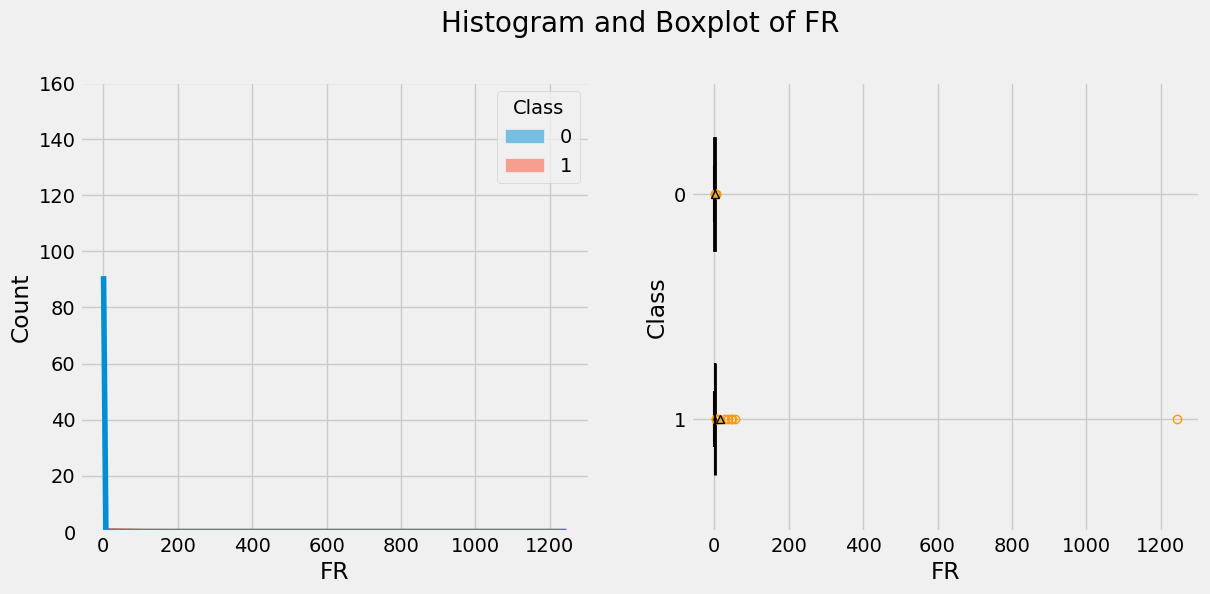

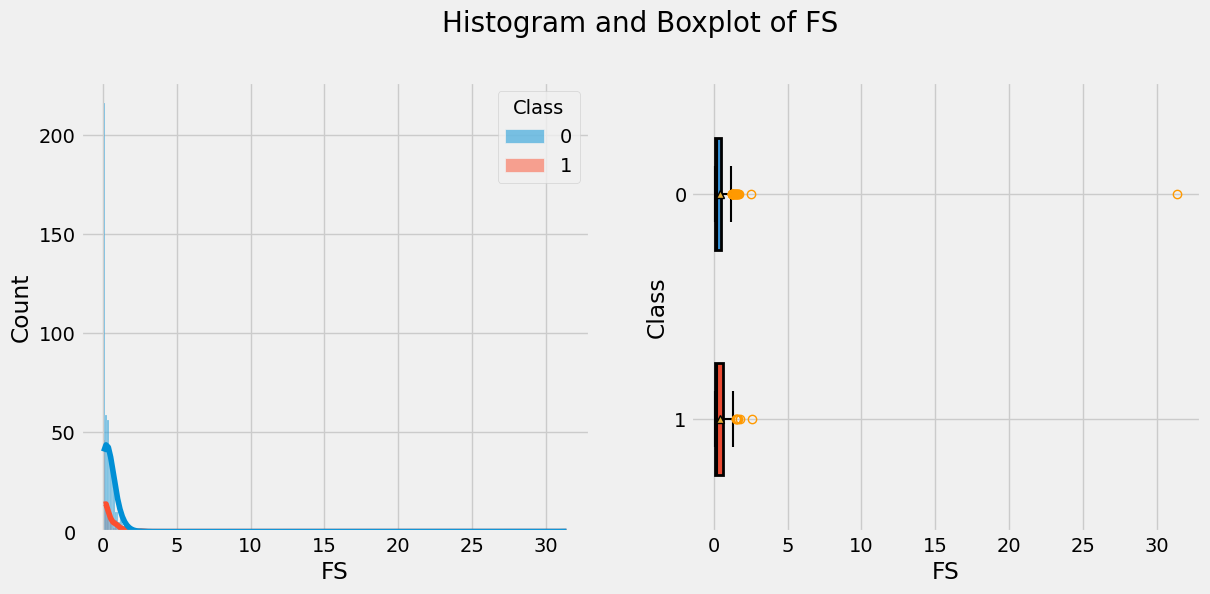

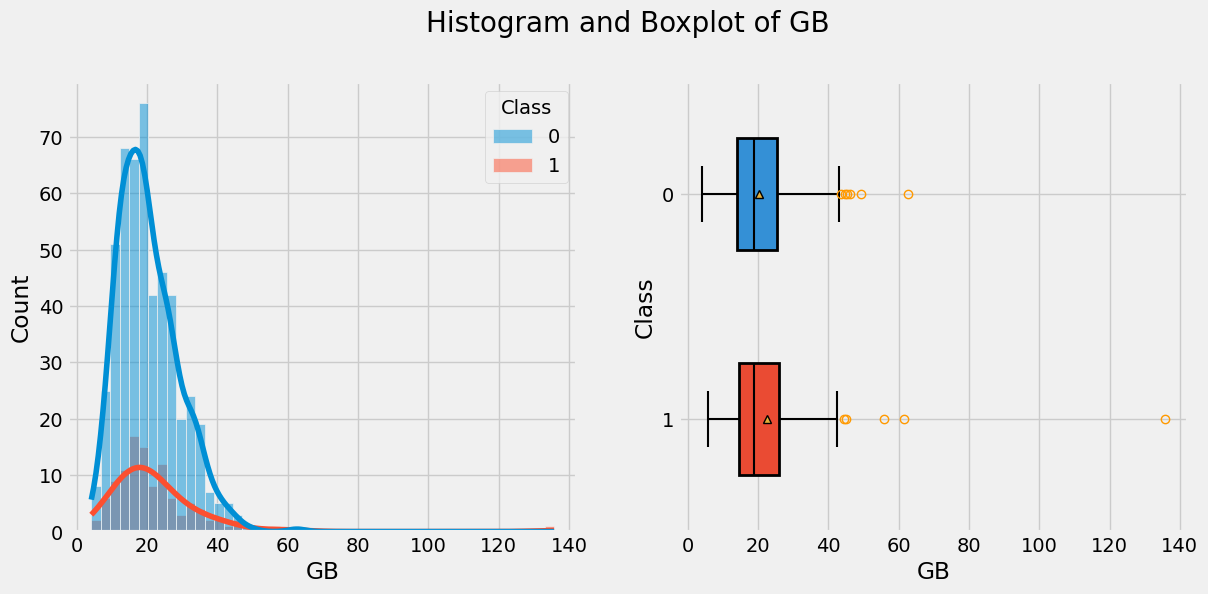

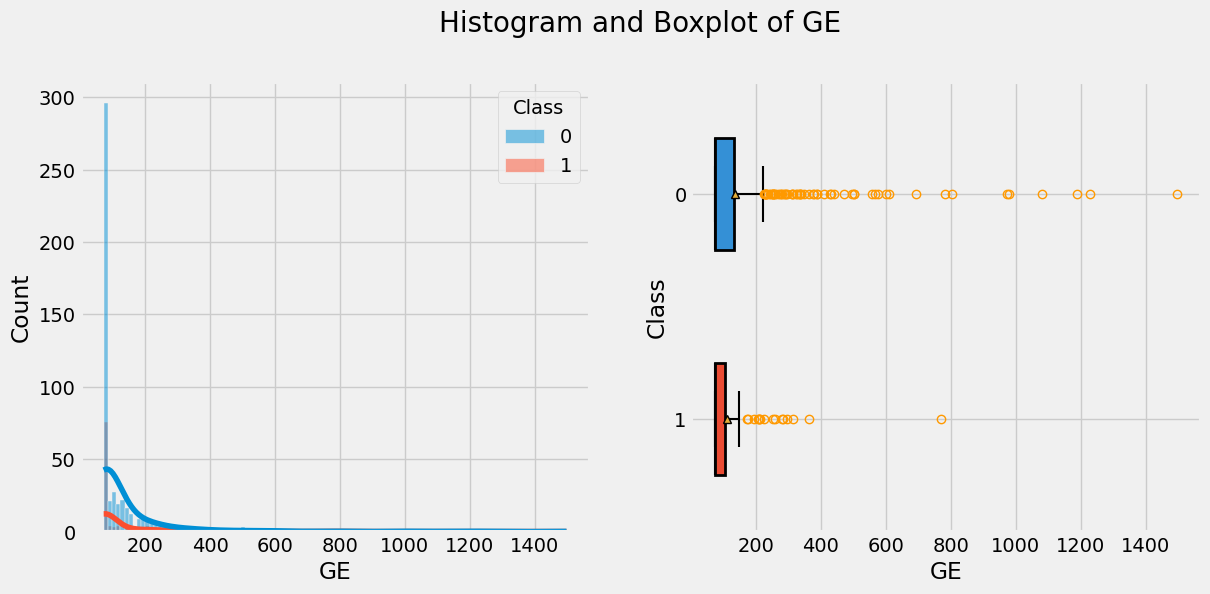

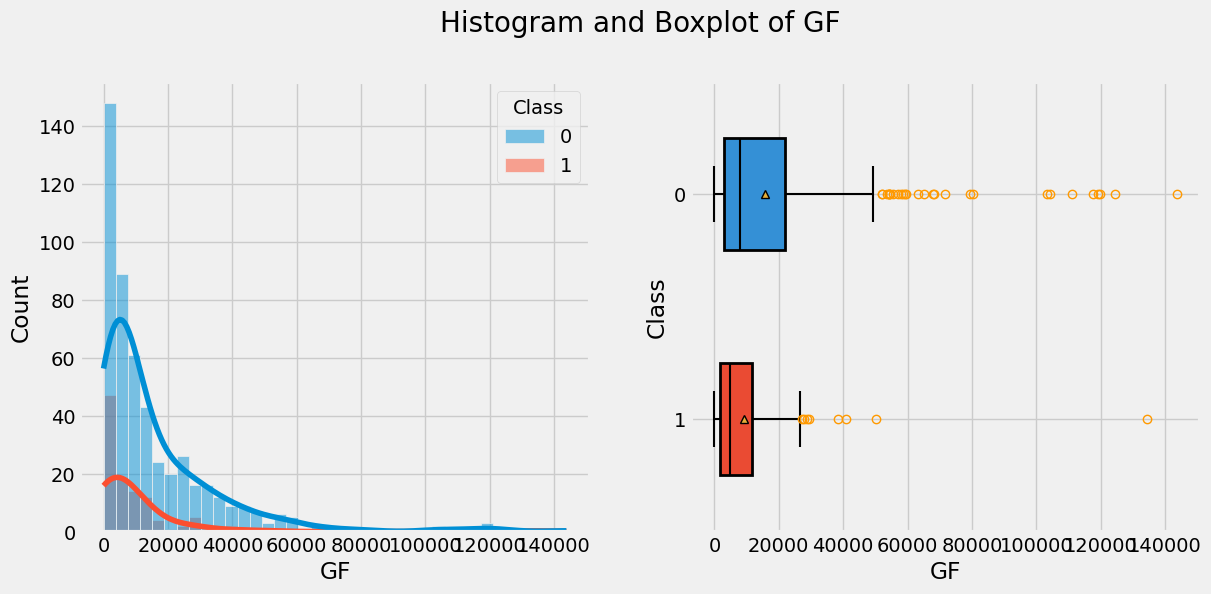

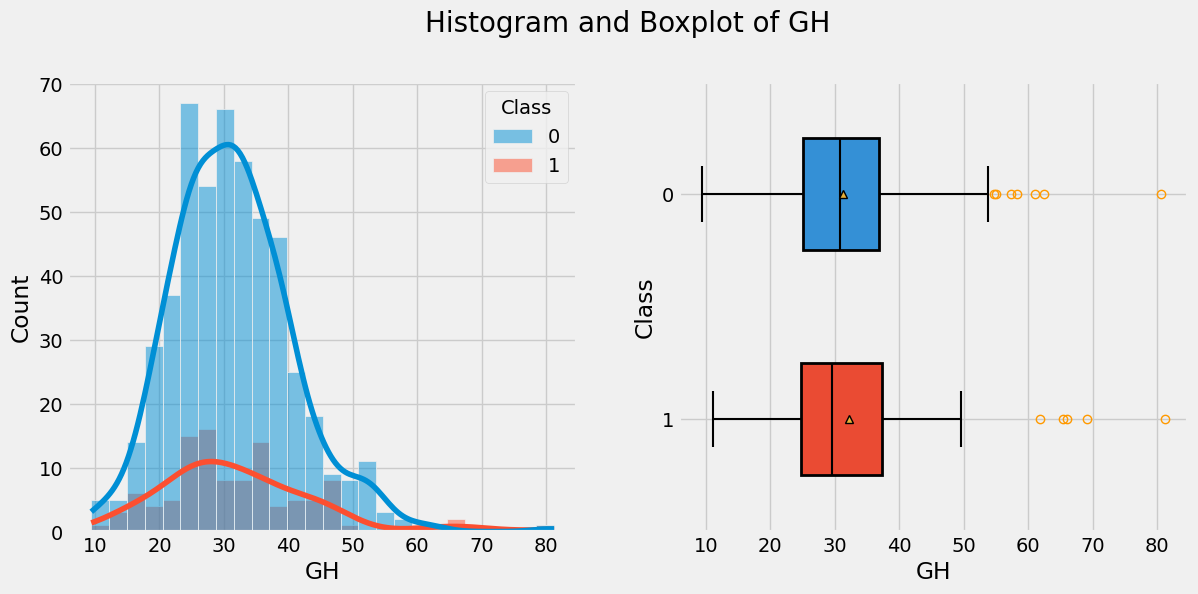

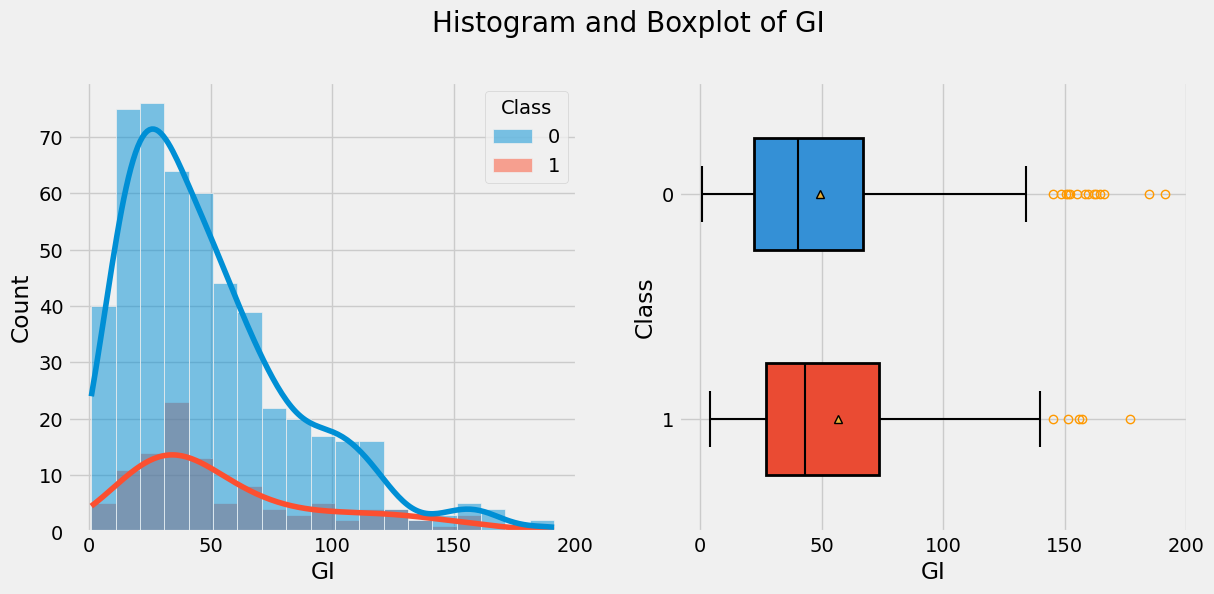

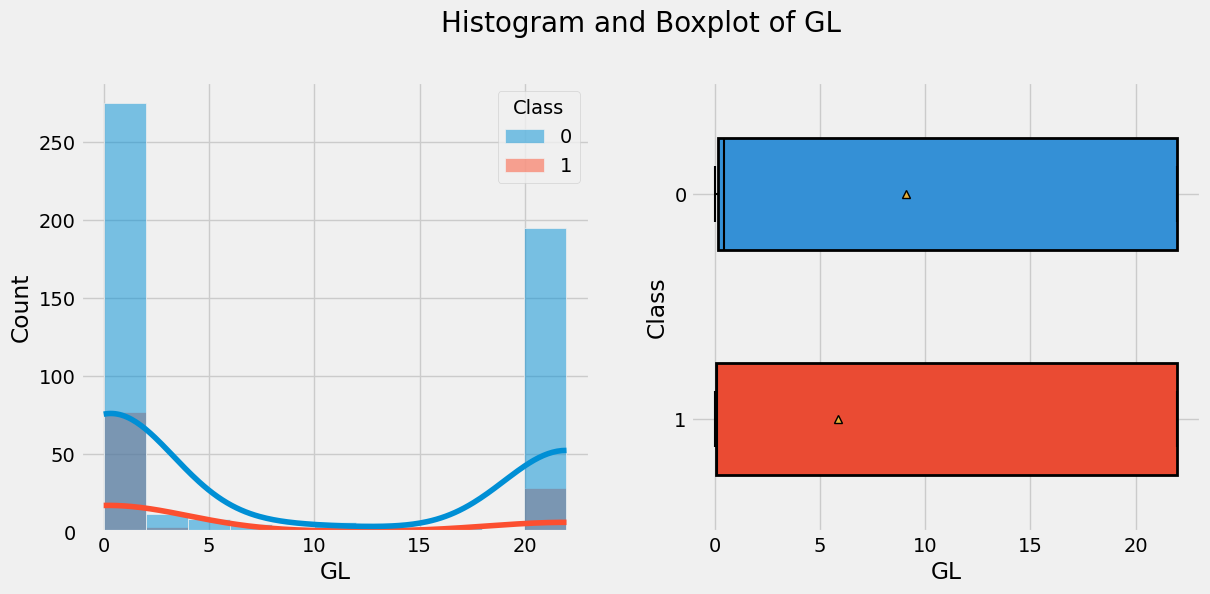

----------------------------------------------------------------------------------------------------
Countplot(s):



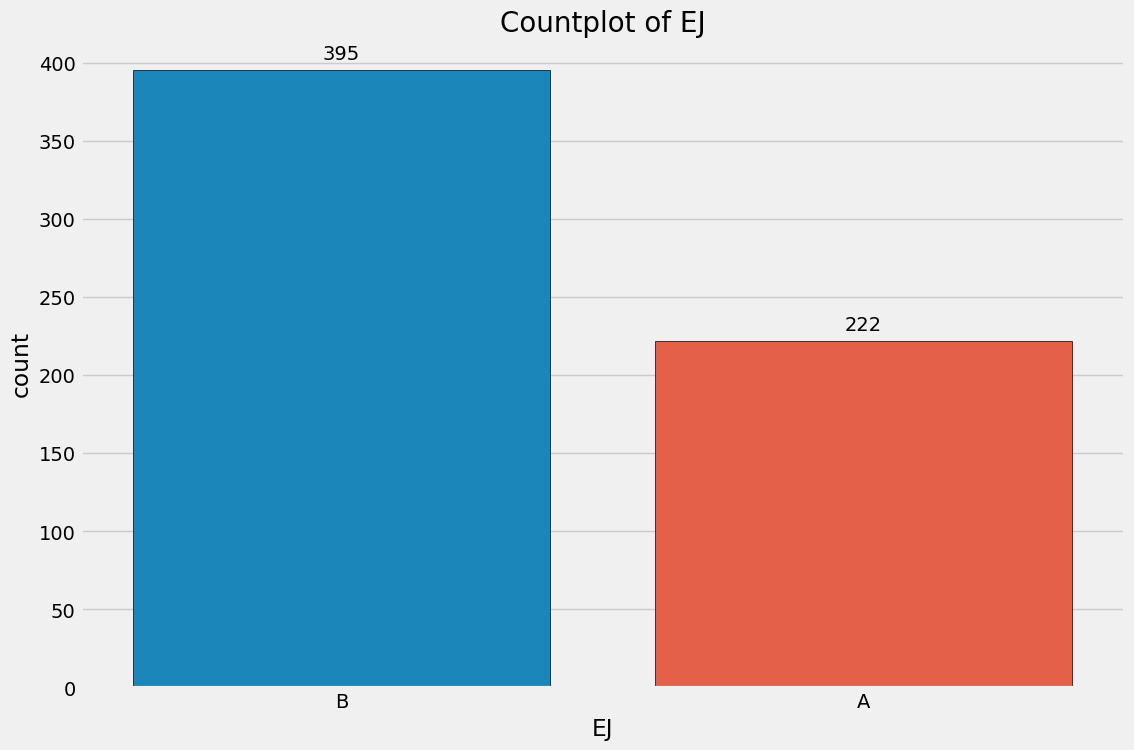

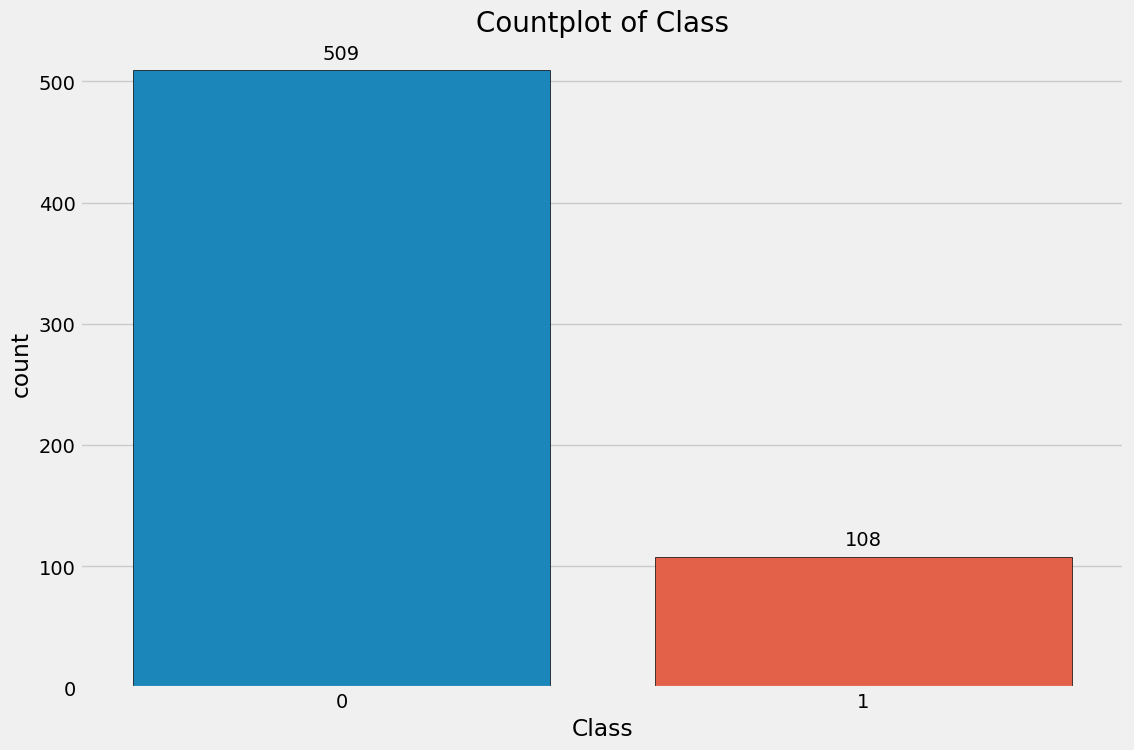

In [13]:
from fasteda import fast_eda
fast_eda(train_df, target='Class', correlation=True, pairplot=True, hist_box_plot=True, countplot=True)

There is a huge class imbalance. We need to downsample the dataframe to have an equal amount of diagnosed/non diagnosed cases, helping our algorithms better understand patterns .

#### Correlations

In [25]:
# Encode categorical features
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns
df= train_df.drop(['Id'], axis=1)
df, le_encoded_cols = label_encoder(df, None)

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Find the correlated variables
correlated_variables1 = set()
correlated_variables2 = set()
n_variables = len(correlation_matrix.columns)

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Set your correlation threshold here
            variable_1 = correlation_matrix.columns[i]
            variable_2 = correlation_matrix.columns[j]
            correlated_variables1.add(variable_1)
            correlated_variables2.add(variable_2)
print(f"correlated_variables1 {correlated_variables1 } " )
print(f"correlated_variables2 {correlated_variables2 }  ")


correlated_variables1 {'EH', 'CL', 'EJ', 'DU', 'AR', 'BC'} 
correlated_variables2 {'BZ', 'EH', 'GL', 'DV', 'FD '}  


In [45]:
from scipy import stats

# Fill NaNs with mean
df_filled = df.fillna(df.mean())

for column in df_filled.columns:
  # Assuming 'df' is your DataFrame and 'feature' is the column you're interested in.
  Q1 = df_filled[column].quantile(0.25)
  Q3 = df_filled[column].quantile(0.75)
  IQR = Q3 - Q1

  # Define criteria for an outlier
  outlier_condition = (df_filled[column] < (Q1 - 1.5 * IQR)) | (df_filled[column] > (Q3 + 1.5 * IQR))

  # Count number of outliers
  num_outliers = outlier_condition.sum()
  if num_outliers>0:
    print(f"Column {column} with a more than hundred of outliers: {num_outliers}")

Column AB with a more than hundred of outliers: 35
Column AF with a more than hundred of outliers: 19
Column AH with a more than hundred of outliers: 70
Column AM with a more than hundred of outliers: 54
Column AR with a more than hundred of outliers: 133
Column AX with a more than hundred of outliers: 27
Column AY with a more than hundred of outliers: 107
Column AZ with a more than hundred of outliers: 14
Column BC with a more than hundred of outliers: 45
Column BD  with a more than hundred of outliers: 15
Column BN with a more than hundred of outliers: 14
Column BP with a more than hundred of outliers: 33
Column BQ with a more than hundred of outliers: 58
Column BR with a more than hundred of outliers: 47
Column BZ with a more than hundred of outliers: 116
Column CB with a more than hundred of outliers: 47
Column CC with a more than hundred of outliers: 25
Column CD  with a more than hundred of outliers: 37
Column CF with a more than hundred of outliers: 38
Column CH with a more than



```
# Imputing missing values

From earlier analysis we found the following data missing values

BQ	60 (Since it has 58 outliers we can use mode to impute values)
CB	2
CC	3
DU	1
EL	60 (Since it has no outliers, we can use mean to imput values)
FC	1
FL	1
FS	2
GL	1

Mean is sensitive to outliers, so for data with many outliers we can use median values.

One of our choices for BQ/EL is to use median.
```



In [ ]:
! pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ss = StandardScaler()

In [ ]:
# Create train/test(validation) split to avoid bias in predictions
X = df.copy()

X.drop('Class', axis = 1, inplace=True)
y = df['Class'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1999)

# We want to standardise/normalise our data for the features (mean = 0 and sd = 1) so that they are of similar scale

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, predictions= model.fit(X_train_scaled, X_test_scaled, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 11.84it/s]


In [ ]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [ ]:
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, predictions= model.fit(X_train_scaled, X_test_scaled, y_train, y_test)
print(listofmodels)

100%|██████████| 29/29 [00:00<00:00, 205.78it/s]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


In [ ]:
# Graph comparing accuracy of each model from LazyClassifier
import plotly.express as px

listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(listofmodels, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()

In [ ]:
# Performing k-fold cross validation to ensure better accuracy due to limited data
# Create train/test(validation) split to avoid bias in predictions
X = df.copy()

X.drop('Class', axis = 1, inplace=True)
y = df['Class'] # Target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Define the KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

X_scaled = ss.fit_transform(X)

for train_index, test_index in kfold.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the LazyClassifier
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    scores.append(models)

# Average the model performances over the folds
avg_scores = pd.concat(scores).groupby(level=0).mean()

print(avg_scores)

100%|██████████| 29/29 [00:02<00:00, 12.26it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.89               0.78     0.78      0.88   
BaggingClassifier                  0.87               0.70     0.70      0.86   
BernoulliNB                        0.84               0.75     0.75      0.84   
CalibratedClassifierCV             0.86               0.65     0.65      0.84   
DecisionTreeClassifier             0.84               0.72     0.72      0.83   
DummyClassifier                    0.81               0.50     0.50      0.73   
ExtraTreeClassifier                0.80               0.66     0.66      0.80   
ExtraTreesClassifier               0.89               0.72     0.72      0.88   
GaussianNB                         0.82               0.64     0.64      0.81   
KNeighborsClassifier               0.88               0.69     0.69      0.86   
LGBMClassifier              

In [ ]:
# Graph comparing accuracy of each model from LazyClassifier
import plotly.express as px

listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(avg_scores, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()

In [ ]:
# Performing k-fold cross validation to ensure better accuracy due to limited data
# Create train/test(validation) split to avoid bias in predictions
X = df.copy()

X.drop('Class', axis = 1, inplace=True)
y = df['Class'] # Target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Define the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []

X_scaled = ss.fit_transform(X)

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the LazyClassifier
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    scores.append(models)

# Average the model performances over the folds
avg_scores = pd.concat(scores).groupby(level=0).mean()

print(avg_scores)

100%|██████████| 29/29 [00:02<00:00, 11.93it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.88               0.76     0.76      0.87   
BaggingClassifier                  0.88               0.74     0.74      0.87   
BernoulliNB                        0.84               0.74     0.74      0.84   
CalibratedClassifierCV             0.86               0.65     0.65      0.83   
DecisionTreeClassifier             0.86               0.74     0.74      0.86   
DummyClassifier                    0.81               0.50     0.50      0.73   
ExtraTreeClassifier                0.80               0.68     0.68      0.80   
ExtraTreesClassifier               0.89               0.72     0.72      0.88   
GaussianNB                         0.84               0.67     0.67      0.83   
KNeighborsClassifier               0.87               0.68     0.68      0.84   
LGBMClassifier              

In [ ]:
# Graph comparing accuracy of each model from LazyClassifier
import plotly.express as px

listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(avg_scores, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()

In [ ]:
# Graph comparing accuracy of each model from LazyClassifier
import plotly.express as px

listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(listofmodels, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()